# Deep Reinforcement Learning (DRL) by Yousef Qasim

## Install dependencies

In [1]:
import pandas as pd
from pandas import to_datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import gym
from gym import spaces
import gym_anytrading
from gym_anytrading.envs import StocksEnv, TradingEnv
import quantstats as qs

from stable_baselines3 import PPO,A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

import os
import time

import Trading


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.2.0)/charset_normalizer (None) doesn't match a supported version!
  RequestsDependencyWarning,


## Data Preprocessing

### Compile Hourly Data

In [2]:
temp_data_0 = pd.read_csv(r"C:\Users\buste\Downloads\OANDA_SPX500USD, 240.csv")
temp_data_1 = pd.read_csv(r"C:\Users\buste\Downloads\OANDA_SPX500USD, 240 (1).csv")
temp_data_2 = pd.read_csv(r"C:\Users\buste\Downloads\OANDA_SPX500USD, 240 (2).csv")
temp_data_3 = pd.read_csv(r"C:\Users\buste\Downloads\OANDA_SPX500USD, 240 (3).csv")
temp_data_4 = pd.read_csv(r"C:\Users\buste\Downloads\OANDA_SPX500USD, 240 (4).csv")
df = pd.concat([temp_data_0, temp_data_1, temp_data_2, temp_data_3, temp_data_4], axis=0)
# drop duplicates
df.drop_duplicates(subset=['time'], keep='first', inplace=True)
# sort by time
df.sort_values(by='time', inplace=True)
# convert column 'time' to datetime and set as index, time is formatted as unix timestamp
df['dt'] = pd.to_datetime(df['time'], unit='s')
# drop column 'time' and set index to 'dt'
df.drop(columns=['time'], inplace=True)
df.set_index('dt', inplace=True)
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
# Filter the date range so it starts from December 2018 and ends in December 2023
df_4h = df.loc['2018-12-01':'2023-12-01']

## Feature engineering for the other 3 datasets.
In total, we will have 4 datasets:
- A. OHLCVD Data
- B. OHLCVD Data + (Custom Built) MarketStructure indicator
- C. OHLCVD Data + Sentiment Analysis Scores from FNSPID
- D. OHLCVD Data + (Custom Built) MarketStructure indicator + Sentiment Analysis Scores from FNSPID

### A. OHLCVD Data

In [3]:
df_a = df_4h.copy()
# Delta is the difference between the closing price of the current period and the previous period's close as a percentage
df_a['Delta'] = df_a['Close'].diff() / df_a['Close'].shift(1)
# Shift the Delta column down by one period to avoid forward bias
df_a['Delta'] = df_a['Delta'].shift(1)
# fill NaN values with 0
df_a.fillna(0, inplace=True)

### B. OHLCVD Data + (Custom Built) MarketStructure indicator

In [4]:
df_b = df_a.copy()

`Trading` a custom built library made from scratch was made to identify breaks and candle types, do post-trading trade analysis in depth and also calculate Market Structure's Highs and Lows' prices and date indices. Finally, we showcase how it can be used to plot a graph highlighting the Market Structure's Highs and Lows being broken with green and red lines.

In [5]:
Trading.identify_breaks(df_b)
df_b['Trend'] = df_b.apply(Trading.determine_trend, axis=1)
df_b = Trading.calculate_distance(df_b)

In [6]:
df_b.head()

Open    High     Low   Close  Volume     Delta     MRH  \
dt                                                                              
2018-12-02 22:00:00  2762.6  2808.4  2762.6  2799.2   13655  0.000000  2808.4   
2018-12-03 02:00:00  2799.2  2808.0  2798.8  2806.4    5610  0.000000  2808.4   
2018-12-03 06:00:00  2806.4  2812.8  2804.6  2808.0   10179  0.002572  2812.8   
2018-12-03 10:00:00  2808.0  2809.0  2794.2  2797.6    9128  0.000570  2812.8   
2018-12-03 14:00:00  2797.6  2801.6  2772.6  2782.6   43540 -0.003704  2812.8   

                        MRL           MRHCandle           MRLCandle  \
dt                                                                    
2018-12-02 22:00:00  2762.6 2018-12-02 22:00:00 2018-12-02 22:00:00   
2018-12-03 02:00:00  2762.6 2018-12-02 22:00:00 2018-12-02 22:00:00   
2018-12-03 06:00:00  2798.8 2018-12-03 06:00:00 2018-12-03 02:00:00   
2018-12-03 10:00:00  2794.2 2018-12-03 06:00:00 2018-12-03 10:00:00   
2018-12-03 14:00:00  2772.6 2018-12-03 06:00:00 2018-12-03 14:00:00   

                     BreakDirection  BreakCounter Scenario  Trend  \
dt                                                                  
2018-12-02 22:00:00             NaN           0.0               0   
2018-12-03 02:00:00             0.0           0.0        F      0   
2018-12-03 06:00:00             1.0           1.0        A     10   
2018-12-03 10:00:00            -1.0          -1.0        C    -10   
2018-12-03 14:00:00            -1.0          -1.0        D    -10   

                     MRHDistance  MRLDistance  
dt                                             
2018-12-02 22:00:00            0            0  
2018-12-03 02:00:00            1            1  
2018-12-03 06:00:00            0            1  
2018-12-03 10:00:00            1            0  
2018-12-03 14:00:00            2            0

In [7]:
Trading.plot_candlestick(df_b[100:250]) # only 1000 as with a big amount of data it is hard to see the candlesticks.

In [8]:
# Shifting the specified columns by -1 as to not contaminate the current row with future data
# Columns to shift
columns_to_shift = ['MRH', 'MRL', 'BreakDirection', 'BreakCounter', 'Trend', 'MRHDistance', 'MRLDistance']
df_b[columns_to_shift] = df_b[columns_to_shift].shift(1)

We want to turn the high and low into a percentage of where price is.

So for example, if price's Most recent high (MRH) is at 500, Most recent low is at 100 and the price is at 300, then:
1. We find out whether price is in a bullish leg or bearish leg, as this decides if the percentage will be negative or positive.
2. a. If positive, we subtract MRL from current close. E.g. 300 - 100 = 200. This is called value a
2. b. If negative, we subtract MRH from current close. E.g. 300 - 500 = -200. This is called value a
3. Then we divide by the absolute value of the price range between the MRH and MRL = abs(500-100) = 400. This is called value b 
4. df['pct'] = a / b


With this feature, the DRL algorithm will be able to deduce:
1. If a value is greater than 1, or less than -1, we are breaking structure.
2. If a value is greater than 0 but less than 1, we are in a positive leg, if a value is less than 0 but greater than -1, we are in a negative leg.

In [9]:
def calculate_pct(df):
    # Calculate value 'a' based on bullish or bearish leg
    df['a'] = df.apply(lambda row: row['Close'] - row['MRL'] if row['Close'] > row['MRL'] else row['Close'] - row['MRH'], axis=1)
    # Calculate value 'b', the absolute range between MRH and MRL
    df['b'] = abs(df['MRH'] - df['MRL'])

    # Calculate the percentage as a/b
    df['pct'] = df['a'] / df['b']

    # Drop the intermediate columns 'a' and 'b'
    df.drop(columns=['a', 'b'], inplace=True)

    return df

# Apply the function
df_b = calculate_pct(df_b)

# Therefore the columns passed through to create the dataset are: Open, High, Low, Close, Volume, BreakCounter, MRHDistance, MRLDistance, pct
df_b = df_b[['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'BreakCounter', 'MRHDistance', 'MRLDistance', 'pct']]


In [10]:
# Fill NaN values with 0
df_b.fillna(0, inplace=True)
# save the dataframe to a csv file
df_b.to_csv('SPX_df_b.csv')

### C. OHLCVD Data + Sentiment Analysis Scores from FNSPID

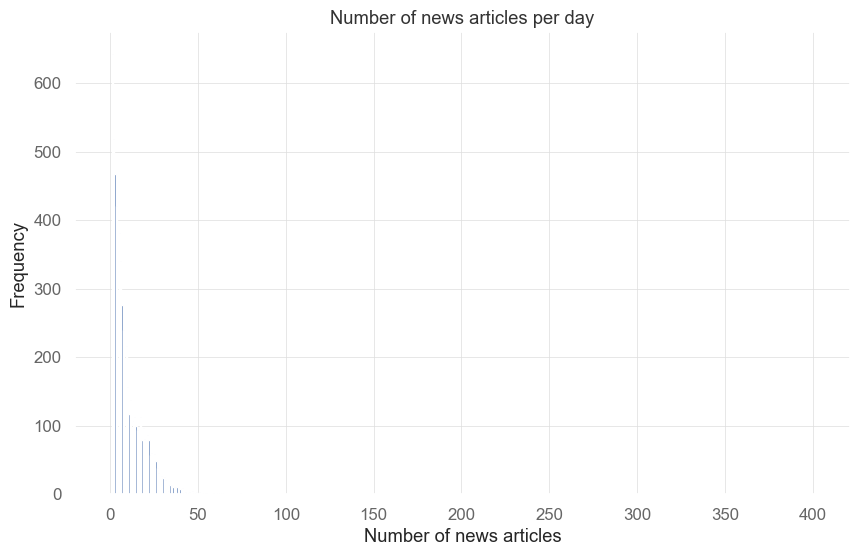

In [11]:
df_c = df_a.copy()
#load csv file with all the news sentiment data
news_data = pd.read_csv(r"C:\Users\buste\Downloads\EURUSD-H1\final_cleaned_results_v1.csv", index_col=0)
# Convert the 'date' column to datetime if not already
news_data['date'] = pd.to_datetime(news_data['date'],utc=True)

# Aggregate sentiment score by date and stock_symbol
sentiment_agg = news_data.groupby([news_data['date'], 'stock_symbol'])['sentiment_score'].count()

# plot a histogram of the number of news articles per day, min 0 max 100, add titles
sentiment_agg.hist(bins=500, figsize=(10, 6), range=(0, 401))
plt.title('Number of news articles per day')
plt.xlabel('Number of news articles')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Load the news sentiment data
news_data = pd.read_csv(r"C:\Users\buste\Downloads\EURUSD-H1\final_cleaned_results_v1.csv", index_col=0)
news_data['date'] = pd.to_datetime(news_data['date'], utc=True)

# Aggregate sentiment scores by day and stock symbol
sentiment_agg = news_data.groupby([news_data['date'].dt.normalize(), 'stock_symbol'])['sentiment_score'].mean().reset_index(name='avg_sentiment_score')

# Convert the df_c index to datetime
df_c['dt'] = pd.to_datetime(df_c.index, utc=True)  # Ensuring timezone-aware
df_c['date'] = df_c['dt'].dt.normalize()

# Create a series to map each date to the next trading day in df_c
trading_days = df_c['date'].drop_duplicates().sort_values()
next_trading_days = trading_days.shift(-1).fillna(method='ffill')  # Fill last day with itself if needed
date_to_next_trading_day = pd.Series(next_trading_days.values, index=trading_days)

# Map sentiment_agg date to the next available trading day
sentiment_agg['date'] = sentiment_agg['date'].map(date_to_next_trading_day)

# Make sure dates in sentiment_agg are timezone-aware (UTC)
sentiment_agg['date'] = pd.to_datetime(sentiment_agg['date'], utc=True)

# Handle potential duplicates due to date mapping before pivoting
sentiment_agg = sentiment_agg.groupby(['date', 'stock_symbol']).agg({'avg_sentiment_score': 'mean'}).reset_index()

# Pivot sentiment_agg to have one column per stock symbol
sentiment_pivot = sentiment_agg.pivot(index='date', columns='stock_symbol', values='avg_sentiment_score')

# Rename the columns to 'sentiment_{SYMBOL}'
sentiment_pivot.columns = ['sentiment_{}'.format(sym) for sym in sentiment_pivot.columns]

# Make sure the index in sentiment_pivot is timezone-aware (UTC)
sentiment_pivot.index = pd.to_datetime(sentiment_pivot.index, utc=True)

# Merge the sentiment scores with the candlestick data, ensuring no overlapping columns besides 'date'
df_c = df_c.merge(sentiment_pivot, how='left', on='date', suffixes=('', '_drop'))
# Drop any duplicated columns that may have resulted from the merge
df_c = df_c[[col for col in df_c.columns if not col.endswith('_drop')]]

# Save or inspect the DataFrame
df_c.to_csv("SPX_df_c.csv", index=False)

# Load first row of date 22/7/2020 without setting date as index just use datetime column dt 
df_c.set_index('dt', inplace=True)

df_c.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'date',
       'sentiment_AAPL', 'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL',
       'sentiment_MSFT', 'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM'],
      dtype='object')

### D. OHLCVD Data + (Custom Built) MarketStructure indicator + Sentiment Analysis Scores from FNSPID

In [13]:
# Assuming df_c and df_b are your dataframes and that they have a datetime index.
# First, check if the datetime index of each dataframe is timezone-aware or naive.
print(f"df_c index timezone: {df_c.index.tz}")
print(f"df_b index timezone: {df_b.index.tz}")
print(f"Length of df_c before join: {len(df_c)}")
print(f"Length of df_b: {len(df_b)}")
# Ensure both indices have the same timezone setting
if df_c.index.tz != df_b.index.tz:
    if df_c.index.tz is None:
        # Convert df_c index to timezone-aware 'UTC' if df_b index is timezone-aware
        df_c.index = pd.to_datetime(df_c.index).tz_localize('UTC')
    else:
        # Convert df_b index to timezone-aware 'UTC' if df_c index is timezone-aware
        df_b.index = pd.to_datetime(df_b.index).tz_localize('UTC')

# Identify overlapping columns
overlapping_columns = df_c.columns.intersection(df_b.columns)

# Drop overlapping columns from df_b before joining
df_b_unique = df_b.drop(columns=overlapping_columns)

# Join df_c with the non-overlapping parts of df_b
df_d = df_c.join(df_b_unique, how='inner')

# Print the lengths of the original and the new dataframe to check the changes.
print(f"Length of df_d after join: {len(df_d)}")

print(df_d.columns)


df_c index timezone: UTC
df_b index timezone: None
Length of df_c before join: 7725
Length of df_b: 7725
Length of df_d after join: 7725
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'date',
       'sentiment_AAPL', 'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL',
       'sentiment_MSFT', 'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM',
       'BreakCounter', 'MRHDistance', 'MRLDistance', 'pct'],
      dtype='object')


## Deep Reinforcement Learning

In [14]:
print("Training data starts from index 0 to:", str(len(df_a) - len(df_a.loc['2022-12-01':])))

Training data starts from index 0 to: 6172


### Common functions and classes
Any function or class to be used iteratively can be placed here to make the code shorter.

In [15]:
# Define the environment Monitor
class MemoryMonitor(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.data = []
        self.current_episode_rewards = []

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.current_episode_rewards.append(reward)
        if done:
            self.data.append({
                'total_reward': sum(self.current_episode_rewards),
                'length': len(self.current_episode_rewards)
            })
            self.current_episode_rewards = []  # Reset for next episode
        return observation, reward, done, info

    def get_statistics(self):
        total_rewards = [ep['total_reward'] for ep in self.data]
        lengths = [ep['length'] for ep in self.data]
        average_reward = sum(total_rewards) / len(total_rewards) if total_rewards else 0
        average_length = sum(lengths) / len(lengths) if lengths else 0
        return {'average_reward': average_reward, 'average_length': average_length}

In [16]:
np.random.seed(42)

### Deep Reinforcement Learning (df_a)

In [17]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume','Delta']].to_numpy()[start:end]
    print("Prices shape:", prices.shape)  # Should be (window_size,)
    print("Signal features shape:", signal_features.shape)  # Should be (window_size, num_features)
    return prices, signal_features
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
log_path = os.path.join(r'C:/Training', 'Logs')
print(df_a.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta'], dtype='object')


In [269]:
def make_env(seed=None):  # Accept a seed argument
    def _init():
        env = MyCustomEnv(df=df_a, window_size=100, frame_bound=(100,6172))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        env.seed(seed)  # Use the passed seed
        print(f"Environment seed set to: {seed}")
        return env
    return _init

# Generate unique seeds for each environment, for example using a range starting from 2002
unique_seeds = [2002 + i for i in range(4)]

# Create a list of environment instances with unique seeds
envs = [make_env(seed=s) for s in unique_seeds]  # Pass different seeds to each environment

# Proceed with creating the vectorized environment and model as before
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 64, 32], vf=[128, 64, 32])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path, seed = 2002,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=10000000)

TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 6)
Environment seed set to: 2002
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 6)
Environment seed set to: 2003
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 6)
Environment seed set to: 2004
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 6)
Environment seed set to: 2005
Using cpu device
Logging to C:/Training\Logs\PPO_55


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 3101 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1059        |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.005550814 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.677      |
|    explained_variance   | 0.000179    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.39e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00125    |
|    value_loss           | 2.67e+03    |
-----------------------------------------
----------------------------------

Average Reward: 7569.778345498777
Average Length: 6071.0
TradingEnv __init__
Prices shape: (1653,)
Signal features shape: (1653, 6)
info {'total_reward': 834.0000000000055, 'total_profit': 1.1019387686825093, 'position': 1}


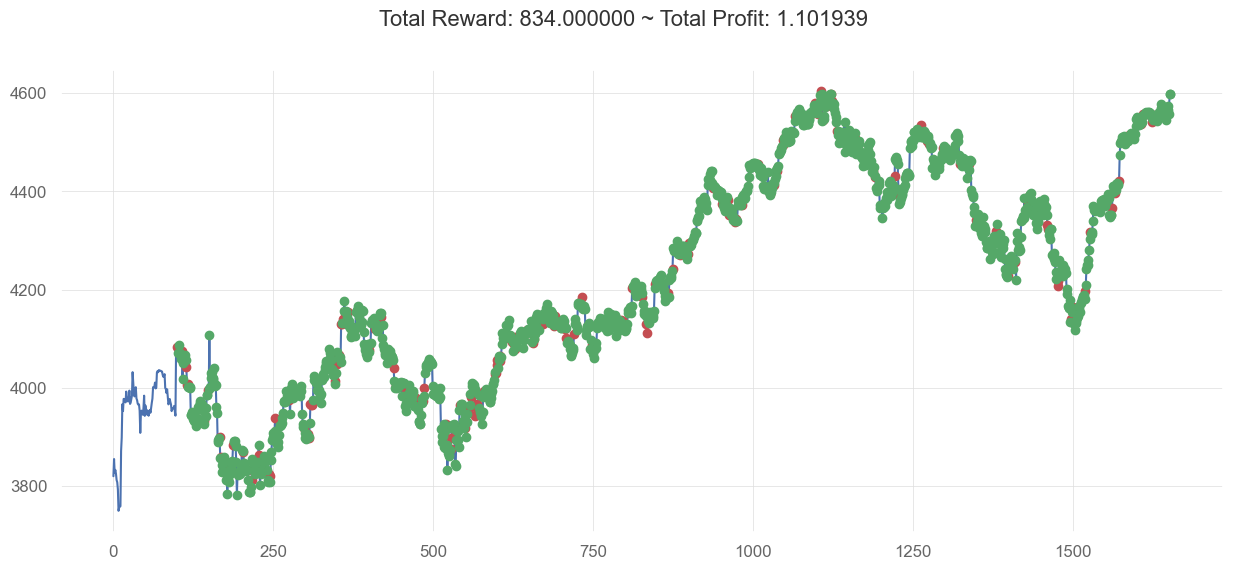

In [270]:
stats = env.get_attr("get_statistics")[0]()
print("Average Reward:", stats['average_reward'])
print("Average Length:", stats['average_length'])
env.close()
env = MyCustomEnv(df=df_a, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done

model.save(r'C:\Users\buste\Downloads\EURUSD-H1\df_a_ppo_model')

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [271]:
df_a.iloc[7724]

Open      4598.600000
High      4599.400000
Low       4586.600000
Close     4597.700000
Volume    4400.000000
Delta        0.008775
Name: 2023-12-01 18:00:00, dtype: float64

In [272]:
env.close()

                           Strategy
-------------------------  ----------
Start Period               2022-12-01
End Period                 2023-12-01
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          8.77%
CAGR﹪                     5.97%

Sharpe                     0.17
Prob. Sharpe Ratio         66.44%
Smart Sharpe               0.12
Sortino                    0.23
Smart Sortino              0.16
Sortino/√2                 0.17
Smart Sortino/√2           0.12
Omega                      1.05

Max Drawdown               -11.67%
Longest DD Days            127
Volatility (ann.)          12.54%
Calmar                     0.51
Skew                       -0.63
Kurtosis                   5.08

Expected Daily %           0.01%
Expected Monthly %         0.65%
Expected Yearly %          4.29%
Kelly Criterion            2.51%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.29%
Expected Shortfall (cVaR)  -1.29%

Max Consecutive Wins       2

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-07-27  2023-10-26  2023-12-01   127    -11.667742        -10.493943
2  2023-02-02  2023-03-14  2023-05-18   105     -8.383171         -7.458620
3  2022-12-01  2022-12-29  2023-02-01    63     -7.913873         -7.519838
4  2023-05-22  2023-05-24  2023-05-26     5     -3.317754         -2.859293
5  2023-06-20  2023-06-26  2023-07-03    14     -3.170376         -3.075351

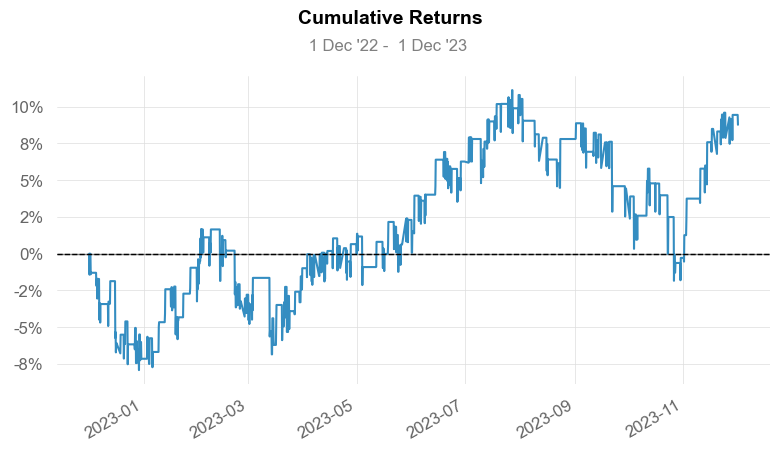

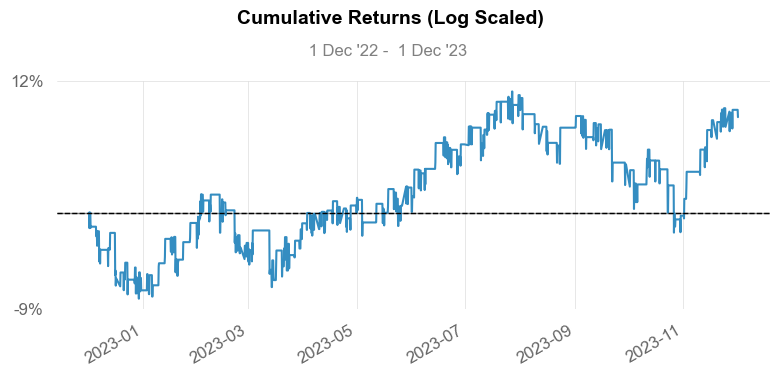

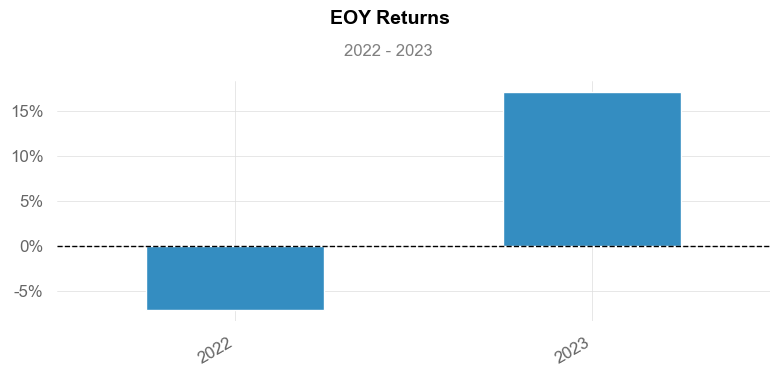

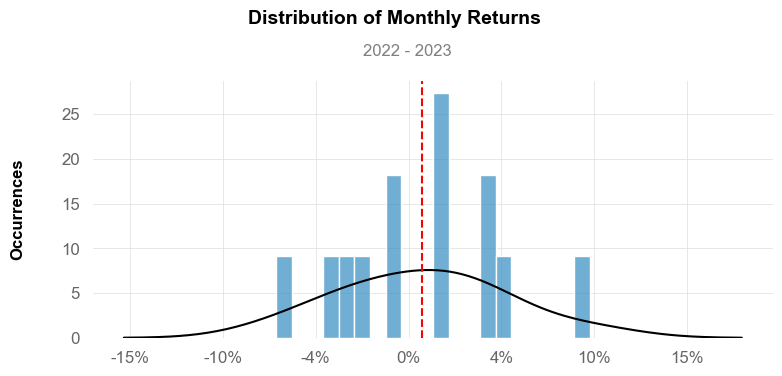

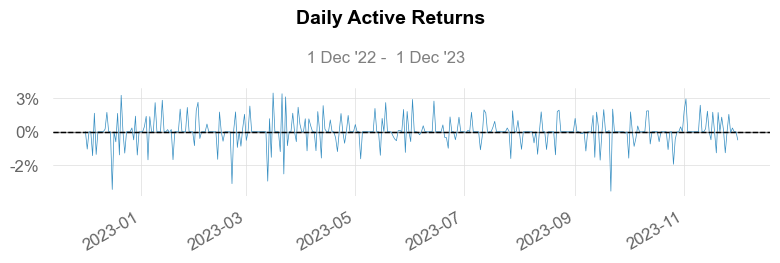

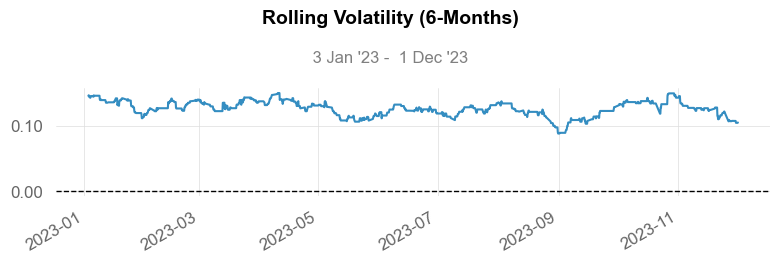

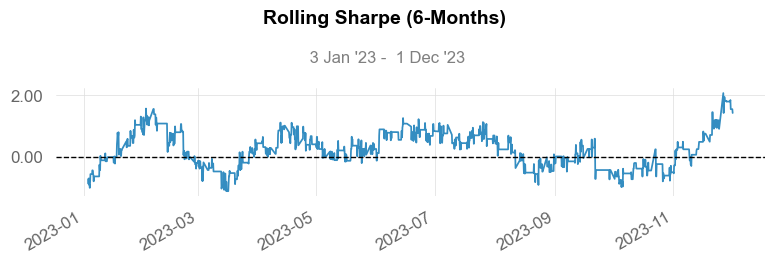

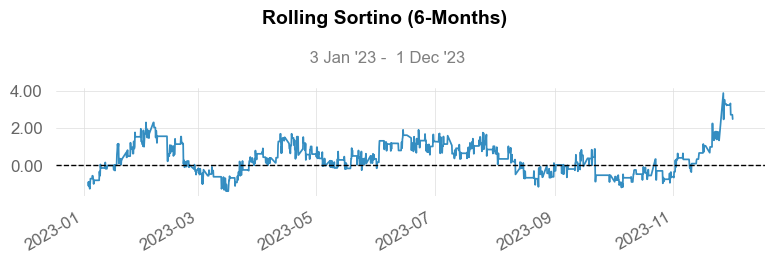

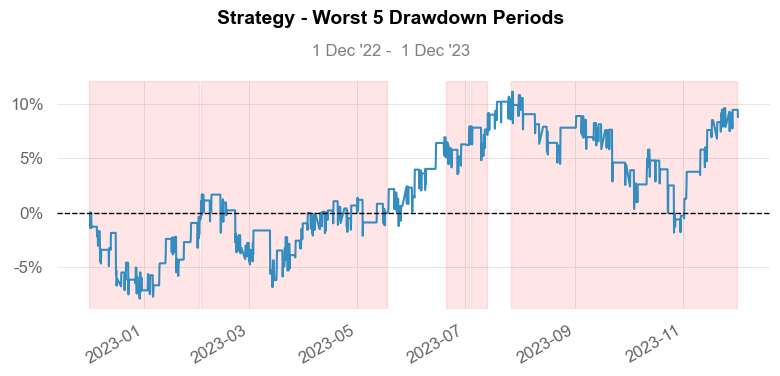

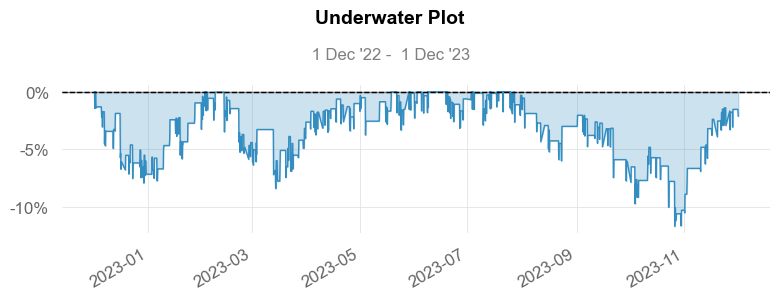

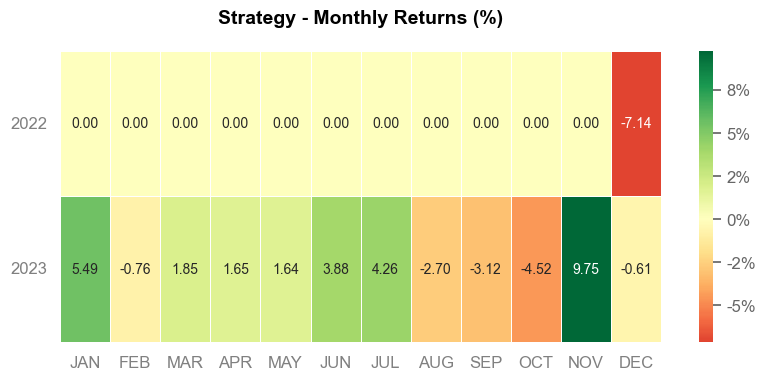

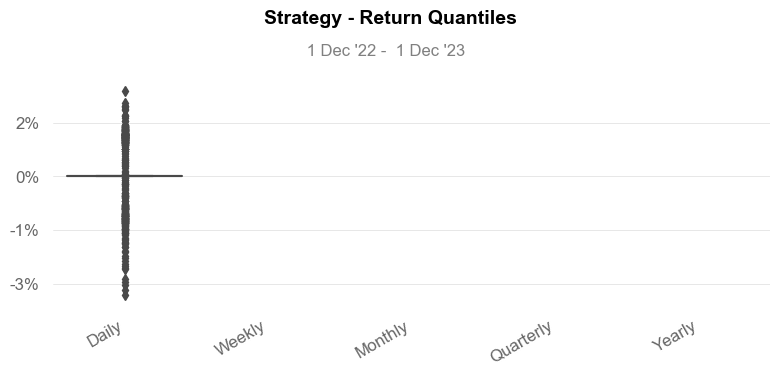

In [273]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df_a.index[6173:7725])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=r'C:\Users\buste\Downloads\EURUSD-H1\df_a_ppo_model_quantstats.html')

In [32]:
env.close()

### Deep Reinforcement Learning (df_b)

In [33]:
# if date is a column,drop it
if 'date' in df_b.columns:
    df_b.drop(columns=['date'], inplace=True)
print(df_b.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'BreakCounter',
       'MRHDistance', 'MRLDistance', 'pct'],
      dtype='object')


In [34]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume','Delta','BreakCounter', 'MRHDistance', 'MRLDistance', 'pct']].to_numpy()[start:end]
    print("Prices shape:", prices.shape)  # Should be (window_size,)
    print("Signal features shape:", signal_features.shape)  # Should be (window_size, num_features)
    return prices, signal_features
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
log_path = os.path.join(r'C:/Training', 'Logs')
print(df_b.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'BreakCounter',
       'MRHDistance', 'MRLDistance', 'pct'],
      dtype='object')


In [277]:
def make_env(seed=None):  # Accept a seed argument
    def _init():
        env = MyCustomEnv(df=df_b, window_size=100, frame_bound=(100,6172))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        env.seed(seed)  # Use the passed seed
        print(f"Environment seed set to: {seed}")
        return env
    return _init

# Generate unique seeds for each environment, for example using a range starting from 2002
unique_seeds = [2002 + i for i in range(4)]

# Create a list of environment instances with unique seeds
envs = [make_env(seed=s) for s in unique_seeds]  # Pass different seeds to each environment

# Proceed with creating the vectorized environment and model as before
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 64, 32], vf=[128, 64, 32])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path, seed = 2002,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=10000000)


TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 10)
Environment seed set to: 2002
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 10)
Environment seed set to: 2003
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 10)
Environment seed set to: 2004
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 10)
Environment seed set to: 2005
Using cpu device
Logging to C:/Training\Logs\PPO_56


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 3033 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1061       |
|    iterations           | 2          |
|    time_elapsed         | 15         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00453158 |
|    clip_fraction        | 0.0619     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.666     |
|    explained_variance   | 7.27e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.36e+03   |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.00156    |
|    value_loss           | 2.41e+03   |
----------------------------------------
------------------------------------------
| time/  

In [278]:
stats_model_b = env.get_attr("get_statistics")[0]()

In [279]:

print("Average Reward:", stats_model_b['average_reward'])
print("Average Length:", stats_model_b['average_length'])
env.close()
env = MyCustomEnv(df=df_b, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done


Average Reward: 4300.162773722622
Average Length: 6071.0
TradingEnv __init__
Prices shape: (1653,)
Signal features shape: (1653, 10)
info {'total_reward': 817.9999999999982, 'total_profit': 1.111484503065712, 'position': 1}


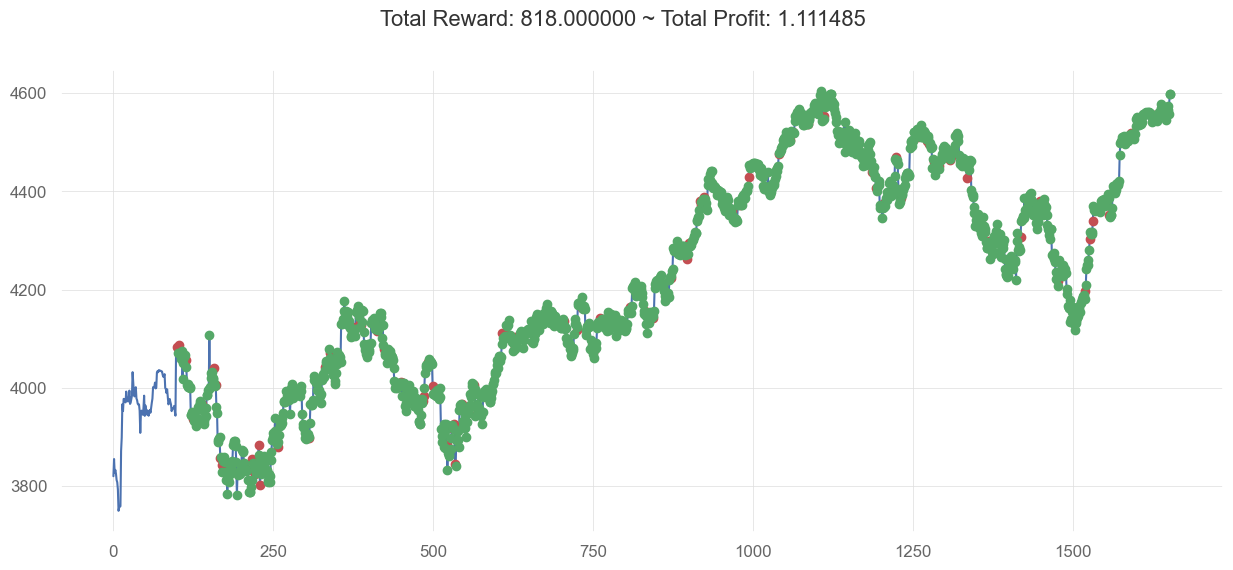

In [280]:
model.save(r'C:\Users\buste\Downloads\EURUSD-H1\df_b_ppo_model')

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-12-01
End Period                 2023-12-01
Risk-Free Rate             0.0%
Time in Market             15.0%

Cumulative Return          9.71%
CAGR﹪                     6.61%

Sharpe                     0.2
Prob. Sharpe Ratio         68.63%
Smart Sharpe               0.14
Sortino                    0.26
Smart Sortino              0.18
Sortino/√2                 0.18
Smart Sortino/√2           0.13
Omega                      1.07

Max Drawdown               -9.84%
Longest DD Days            115
Volatility (ann.)          10.36%
Calmar                     0.67
Skew                       -1.41
Kurtosis                   11.67

Expected Daily %           0.01%
Expected Monthly %         0.72%
Expected Yearly %          4.74%
Kelly Criterion            3.98%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.07%
Expected Shortfall (cVaR)  -1.07%

Max Consecutive Wins       2


None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-08-08  2023-11-01  2023-12-01   115     -9.835466         -8.205942
2  2023-02-15  2023-03-15  2023-05-01    76     -8.500550         -7.210442
3  2022-12-05  2023-01-03  2023-02-06    64     -8.104755         -7.263818
4  2023-05-01  2023-05-04  2023-05-19    18     -3.708742         -2.308450
5  2023-05-24  2023-05-24  2023-06-01     9     -3.082279         -3.063974

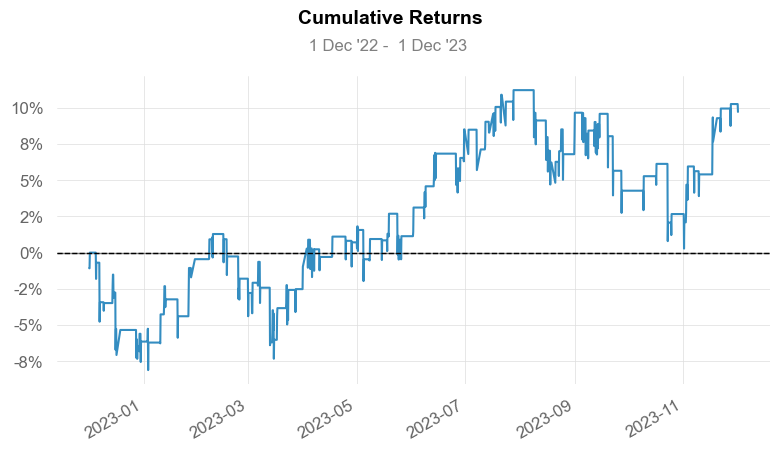

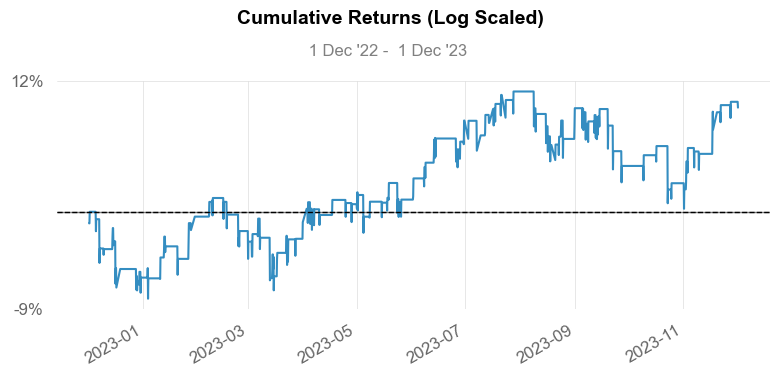

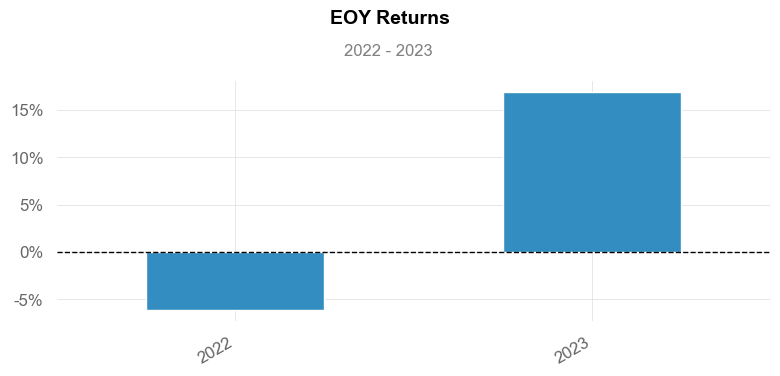

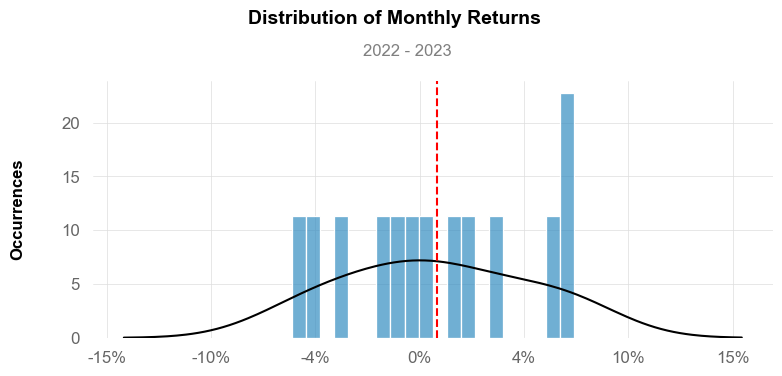

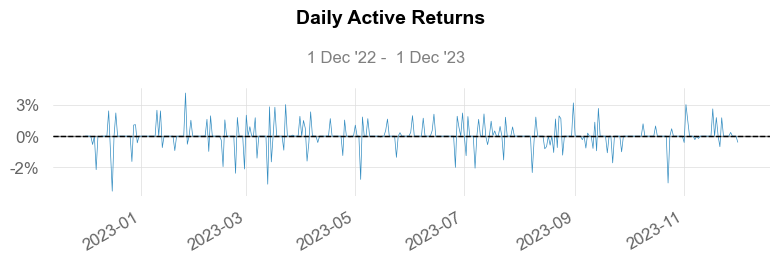

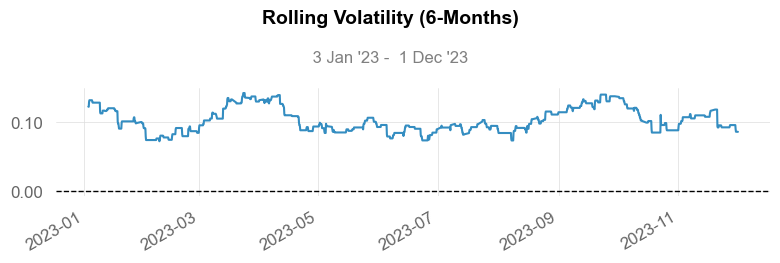

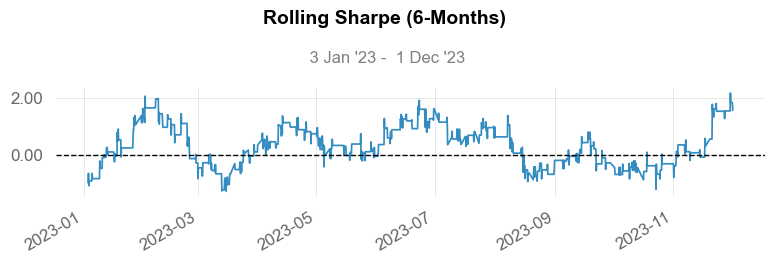

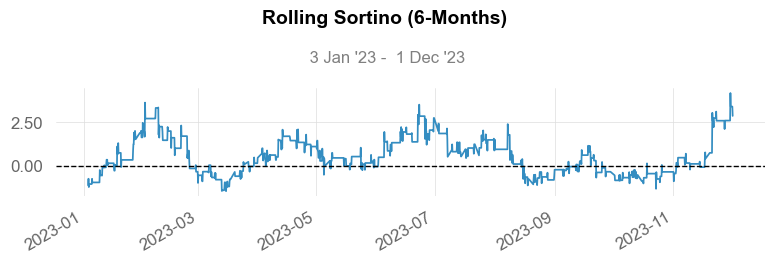

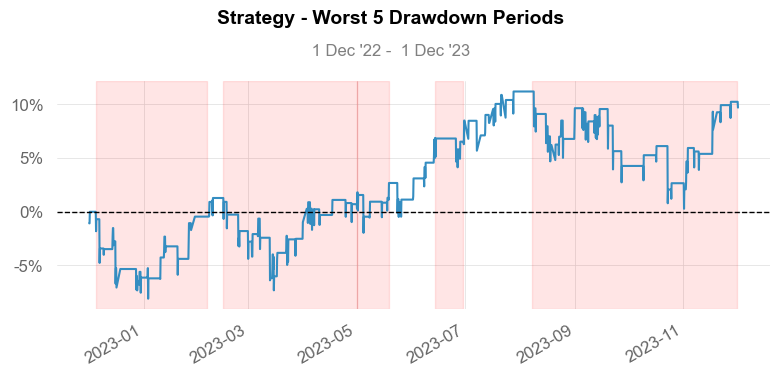

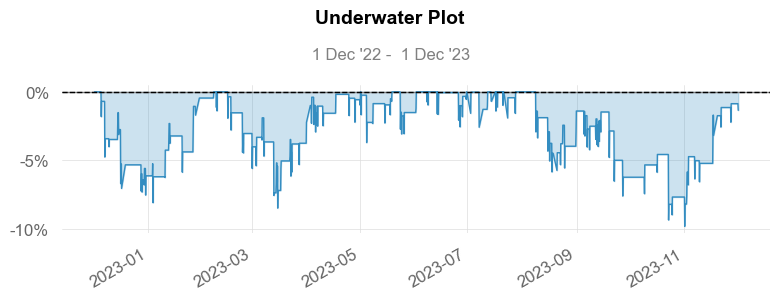

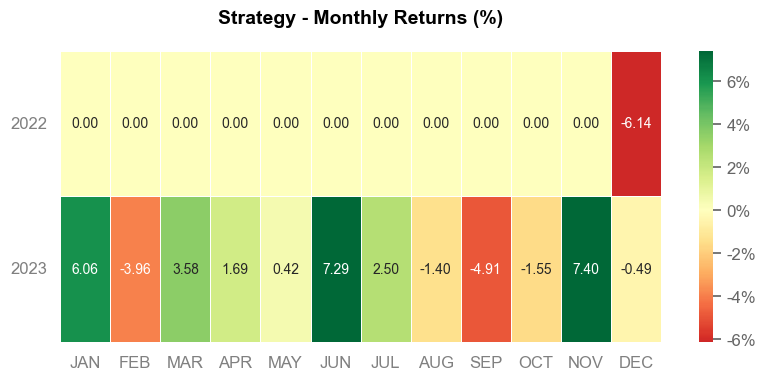

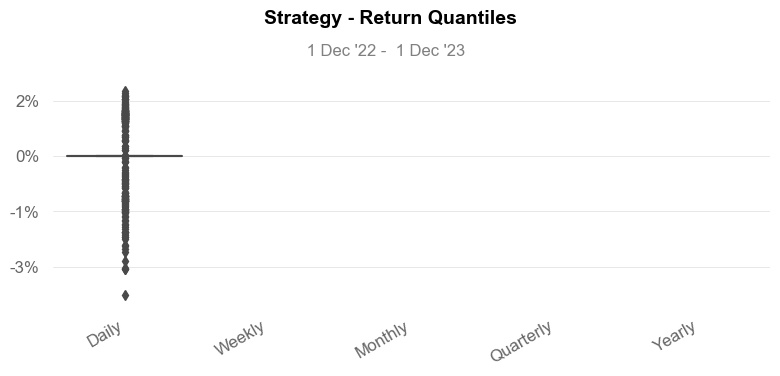

In [281]:
qs.extend_pandas()

net_worth_b = pd.Series(env.unwrapped.history['total_profit'], index=df_b.index[6173:7725])
returns_b = net_worth_b.pct_change().iloc[1:]

qs.reports.full(returns_b)
qs.reports.html(returns_b, output=r'C:\Users\buste\Downloads\EURUSD-H1\df_b_ppo_model_quantstats.html')


In [282]:
env.close()

### Deep Reinforcement Learning (df_c)

In [39]:
if 'date' in df_c.columns:
    df_c.drop(columns=['date'], inplace=True)
print(df_c.columns)
for column in ['sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM']:
    #replace NaN values with 0
    df_c[column].fillna(0, inplace=True)
print(df_c.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM'],
      dtype='object')


In [40]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume', 'Delta',
       'sentiment_AAPL', 'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL',
       'sentiment_MSFT', 'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM']].to_numpy()[start:end]
    print("Prices shape:", prices.shape)  # Should be (window_size,)
    print("Signal features shape:", signal_features.shape)  # Should be (window_size, num_features)
    return prices, signal_features
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
log_path = os.path.join(r'C:/Training', 'Logs')
print(df_c.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM'],
      dtype='object')


In [294]:
def make_env(seed=None):  # Accept a seed argument
    def _init():
        env = MyCustomEnv(df=df_c, window_size=100, frame_bound=(100,6172))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        env.seed(seed)  # Use the passed seed
        print(f"Environment seed set to: {seed}")
        return env
    return _init

# Generate unique seeds for each environment, for example using a range starting from 2002
unique_seeds = [2002 + i for i in range(4)]

# Create a list of environment instances with unique seeds
envs = [make_env(seed=s) for s in unique_seeds]  # Pass different seeds to each environment

# Proceed with creating the vectorized environment and model as before
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 64, 32], vf=[128, 64, 32])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path, seed = 2002,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=10000000)



TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 14)
Environment seed set to: 2002
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 14)
Environment seed set to: 2003
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 14)
Environment seed set to: 2004
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 14)
Environment seed set to: 2005
Using cpu device
Logging to C:/Training\Logs\PPO_59


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 3274 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 992        |
|    iterations           | 2          |
|    time_elapsed         | 16         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00416094 |
|    clip_fraction        | 0.066      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.643     |
|    explained_variance   | 0.000128   |
|    learning_rate        | 0.0003     |
|    loss                 | 1.31e+03   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00144   |
|    value_loss           | 2.43e+03   |
----------------------------------------
-----------------------------------------
| time/   

In [295]:
stats_model_c = env.get_attr("get_statistics")[0]()
print("Average Reward:", stats_model_c['average_reward'])
print("Average Length:", stats_model_c['average_length'])
env.close()
env = MyCustomEnv(df=df_c, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done


Average Reward: 3461.0583941605923
Average Length: 6071.0
TradingEnv __init__
Prices shape: (1653,)
Signal features shape: (1653, 14)
info {'total_reward': -300.69999999999163, 'total_profit': 1.088113658794459, 'position': 1}


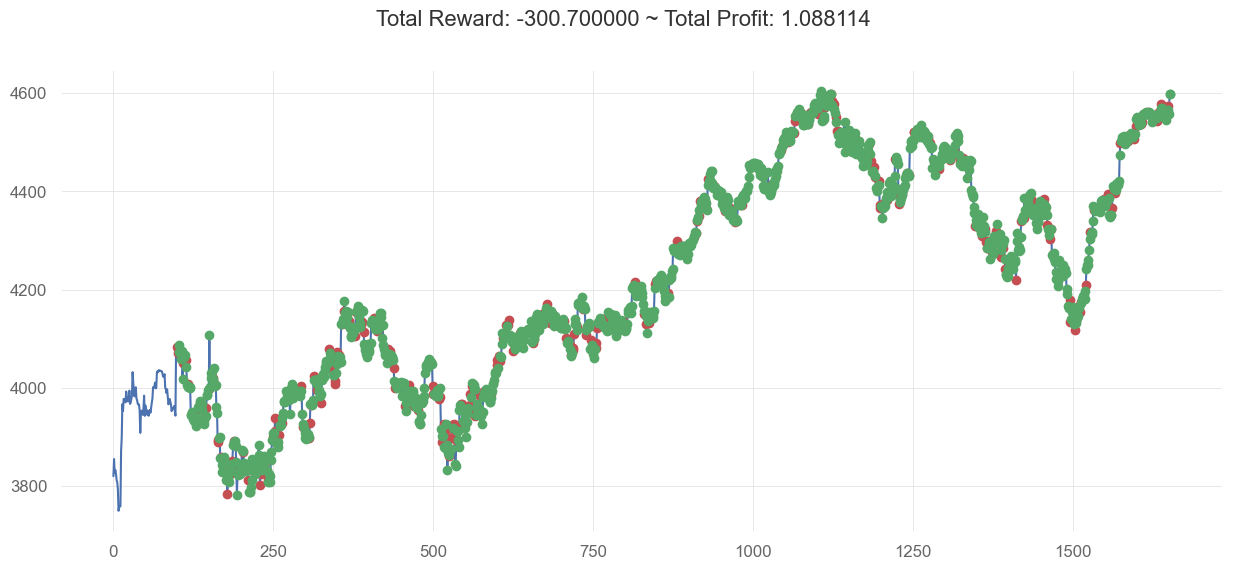

In [296]:
model.save(r'C:\Users\buste\Downloads\EURUSD-H1\df_c_ppo_model')

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-12-01
End Period                 2023-12-01
Risk-Free Rate             0.0%
Time in Market             37.0%

Cumulative Return          8.81%
CAGR﹪                     6.0%

Sharpe                     0.17
Prob. Sharpe Ratio         65.95%
Smart Sharpe               0.11
Sortino                    0.23
Smart Sortino              0.15
Sortino/√2                 0.16
Smart Sortino/√2           0.11
Omega                      1.04

Max Drawdown               -12.19%
Longest DD Days            123
Volatility (ann.)          15.73%
Calmar                     0.49
Skew                       -0.23
Kurtosis                   1.52

Expected Daily %           0.01%
Expected Monthly %         0.65%
Expected Yearly %          4.31%
Kelly Criterion            1.86%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.62%
Expected Shortfall (cVaR)  -1.62%

Max Consecutive Wins       2


None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-08-01  2023-10-27  2023-12-01   123    -12.193182        -10.560029
2  2022-12-14  2022-12-20  2023-02-01    50     -9.345094         -8.773277
3  2023-02-03  2023-03-13  2023-06-05   122     -9.278720         -8.306022
4  2022-12-02  2022-12-09  2022-12-13    11     -5.359736         -4.895405
5  2023-06-18  2023-06-26  2023-07-04    16     -3.443132         -3.388434

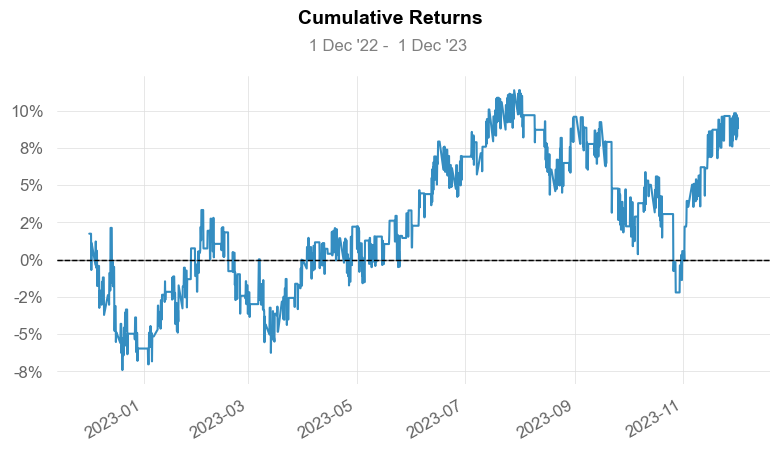

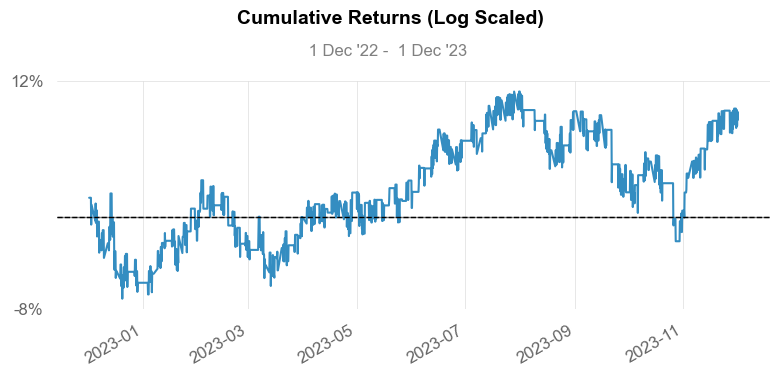

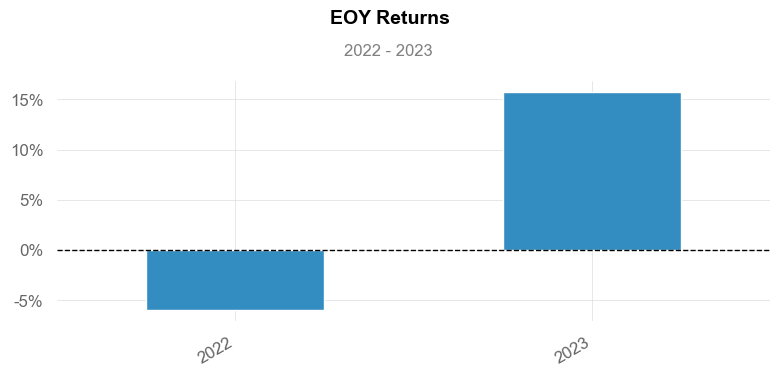

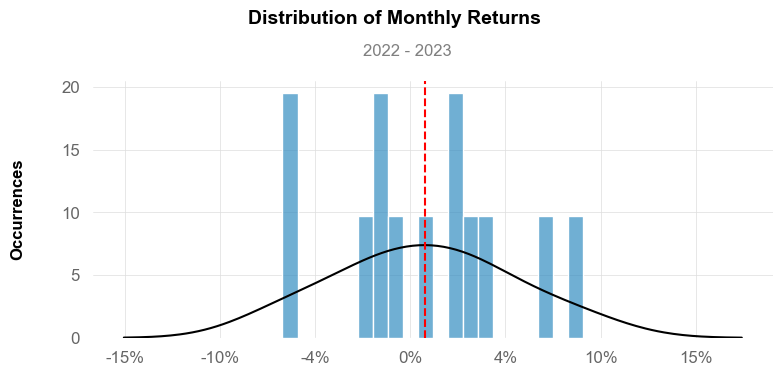

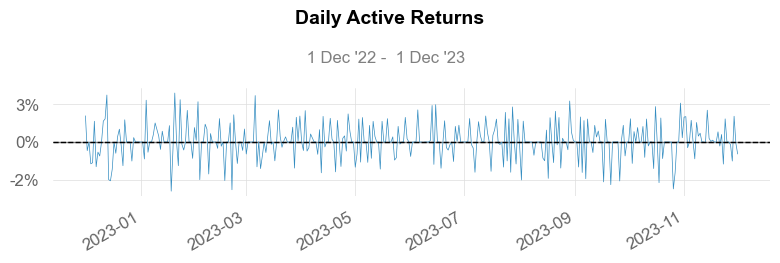

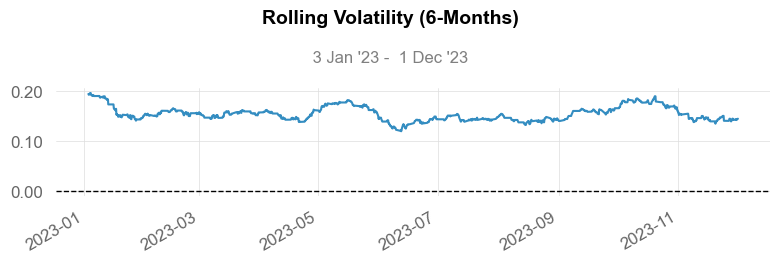

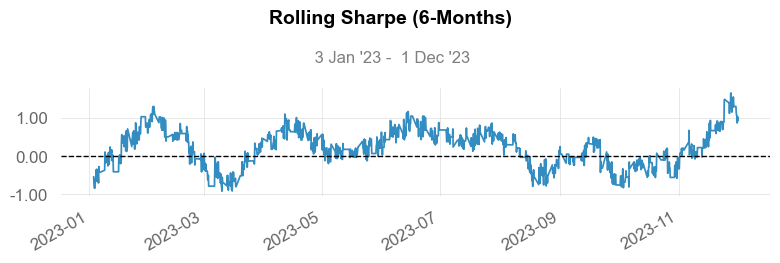

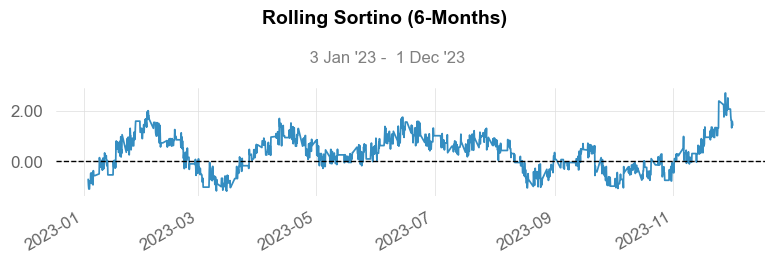

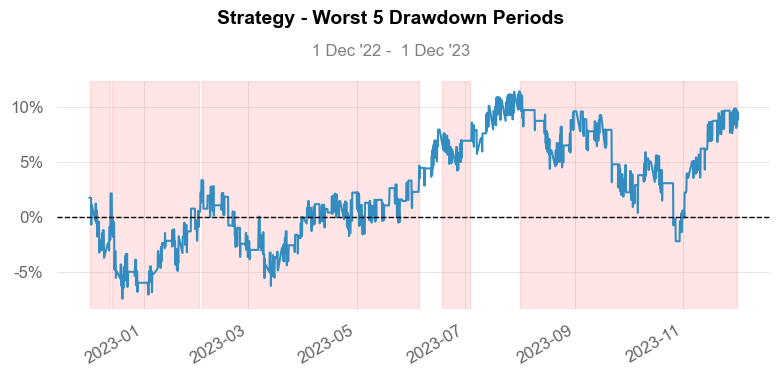

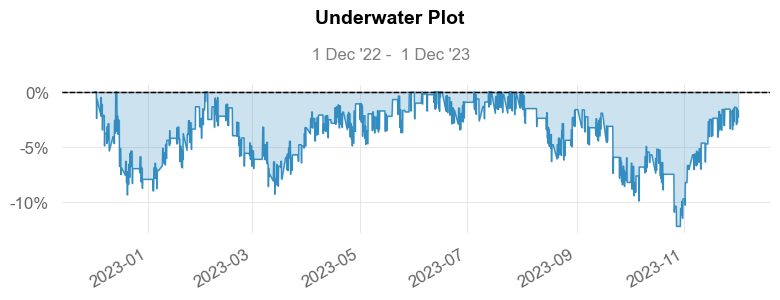

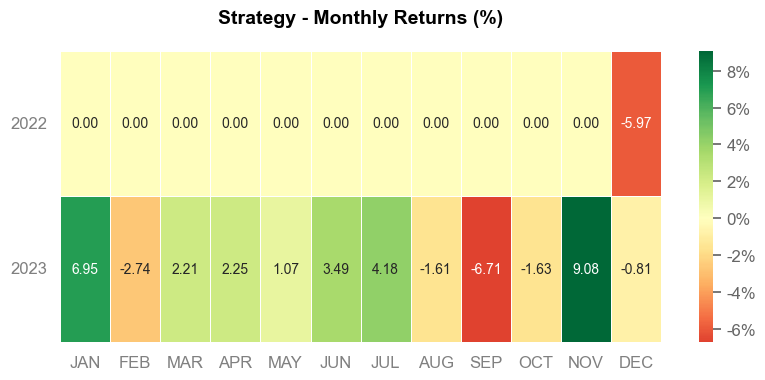

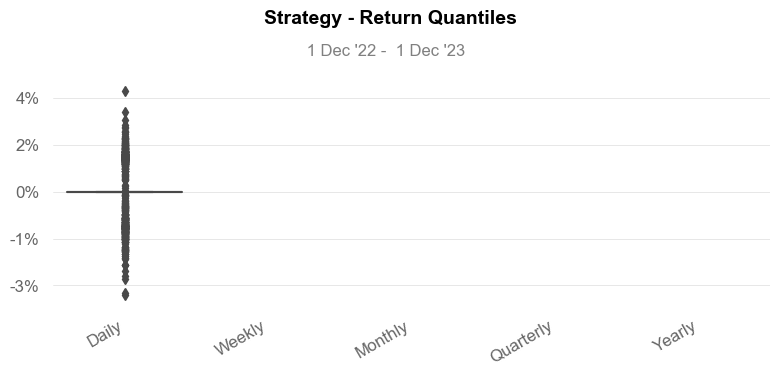

In [297]:
qs.extend_pandas()

net_worth_c = pd.Series(env.unwrapped.history['total_profit'], index=df_c.index[6173:7725])
returns_c = net_worth_c.pct_change().iloc[1:]

qs.reports.full(returns_c)
qs.reports.html(returns_c, output=r'C:\Users\buste\Downloads\EURUSD-H1\df_c_ppo_model_quantstats.html')


In [298]:
env.close()

### Deep Reinforcement Learning (df_d)

In [43]:
if 'date' in df_d.columns:
    df_d.drop(columns=['date'], inplace=True)
print(df_d.columns)
for column in ['sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM']:
    #replace NaN values with 0
    df_d[column].fillna(0, inplace=True)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM', 'BreakCounter',
       'MRHDistance', 'MRLDistance', 'pct'],
      dtype='object')


In [44]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM', 'BreakCounter',
       'MRHDistance', 'MRLDistance', 'pct']].to_numpy()[start:end]
    print("Prices shape:", prices.shape)  # Should be (window_size,)
    print("Signal features shape:", signal_features.shape)  # Should be (window_size, num_features)
    return prices, signal_features
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
log_path = os.path.join(r'C:/Training', 'Logs')
print(df_d.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Delta', 'sentiment_AAPL',
       'sentiment_AMZN', 'sentiment_BRK', 'sentiment_GOGL', 'sentiment_MSFT',
       'sentiment_NVDA', 'sentiment_TSLA', 'sentiment_XOM', 'BreakCounter',
       'MRHDistance', 'MRLDistance', 'pct'],
      dtype='object')


In [305]:
def make_env(seed=None):  # Accept a seed argument
    def _init():
        env = MyCustomEnv(df=df_d, window_size=100, frame_bound=(100,6172))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        env.seed(seed)  # Use the passed seed
        print(f"Environment seed set to: {seed}")
        return env
    return _init

# Generate unique seeds for each environment, for example using a range starting from 2002
unique_seeds = [2002 + i for i in range(4)]

# Create a list of environment instances with unique seeds
envs = [make_env(seed=s) for s in unique_seeds]  # Pass different seeds to each environment

# Proceed with creating the vectorized environment and model as before
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 64, 32], vf=[128, 64, 32])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path, seed = 2002,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=10000000)


TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 18)
Environment seed set to: 2002
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 18)
Environment seed set to: 2003
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 18)
Environment seed set to: 2004
TradingEnv __init__
Prices shape: (6172,)
Signal features shape: (6172, 18)
Environment seed set to: 2005
Using cpu device
Logging to C:/Training\Logs\PPO_61


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 2575 |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.006108751 |
|    clip_fraction        | 0.0435      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 1.6e-05     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.82e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000252   |
|    value_loss           | 2.66e+03    |
-----------------------------------------
----------------------------------

In [306]:
stats_model_d = env.get_attr("get_statistics")[0]()
print("Average Reward:", stats_model_d['average_reward'])
print("Average Length:", stats_model_d['average_length'])
env.close()
env = MyCustomEnv(df=df_d, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done


Average Reward: 2920.241362530408
Average Length: 6071.0
TradingEnv __init__
Prices shape: (1653,)
Signal features shape: (1653, 18)
info {'total_reward': 395.700000000008, 'total_profit': 1.100287029443218, 'position': 1}


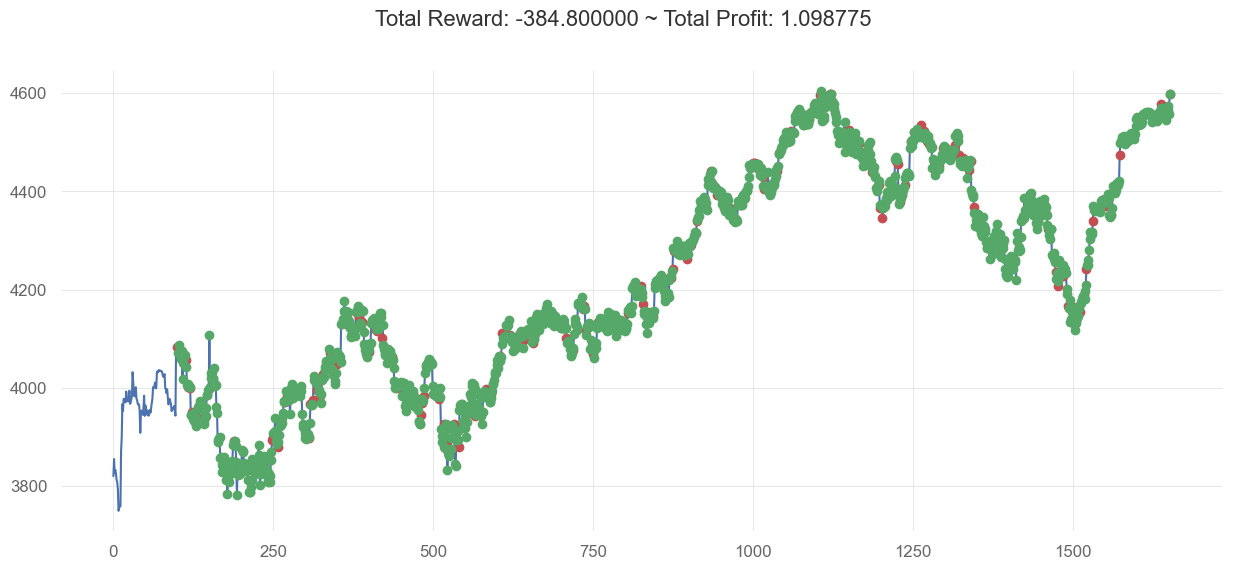

In [30]:
model.save(r'C:\Users\buste\Downloads\EURUSD-H1\df_d_ppo_model')

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-12-01
End Period                 2023-12-01
Risk-Free Rate             0.0%
Time in Market             27.0%

Cumulative Return          8.46%
CAGR﹪                     5.76%

Sharpe                     0.17
Prob. Sharpe Ratio         65.84%
Smart Sharpe               0.1
Sortino                    0.23
Smart Sortino              0.14
Sortino/√2                 0.16
Smart Sortino/√2           0.1
Omega                      1.04

Max Drawdown               -11.71%
Longest DD Days            127
Volatility (ann.)          13.66%
Calmar                     0.49
Skew                       -0.51
Kurtosis                   5.0

Expected Daily %           0.01%
Expected Monthly %         0.63%
Expected Yearly %          4.14%
Kelly Criterion            2.22%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.41%
Expected Shortfall (cVaR)  -1.41%

Max Consecutive Wins       2
Ma

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2023-07-28  2023-10-31  2023-12-01   127    -11.709720        -10.369748
2  2023-02-12  2023-03-13  2023-05-22    99     -8.725712         -7.477359
3  2022-12-21  2022-12-28  2023-02-03    44     -8.108661         -7.710162
4  2022-12-01  2022-12-08  2022-12-13    12     -4.713261         -4.427975
5  2023-06-19  2023-06-25  2023-07-03    15     -3.381558         -3.270953

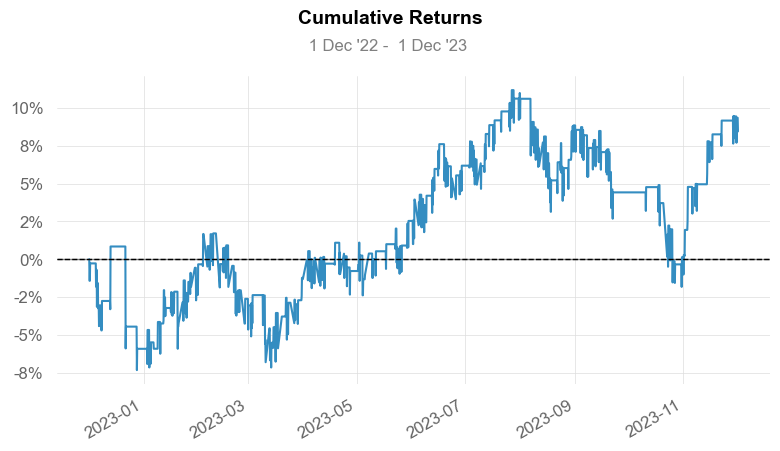

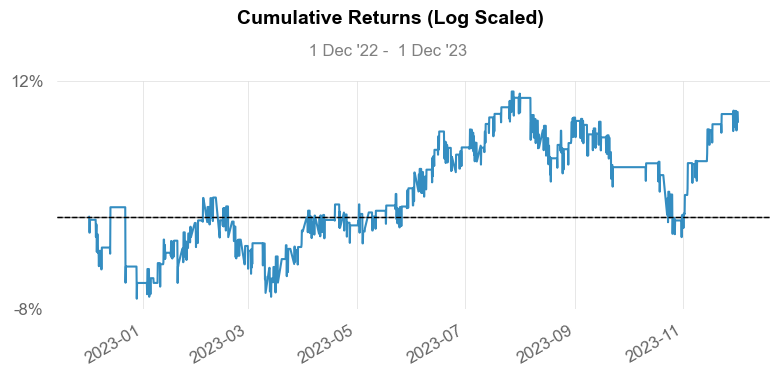

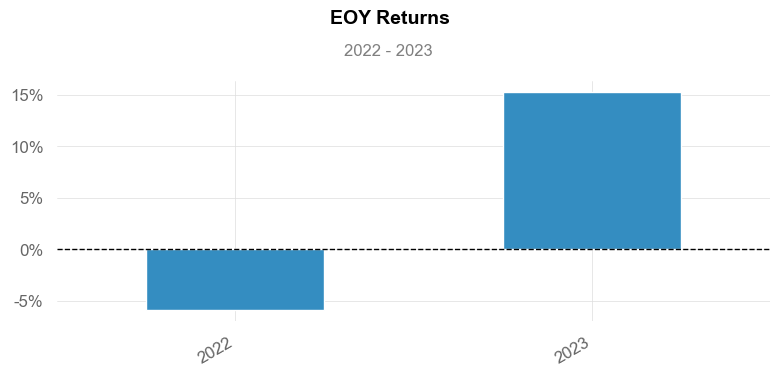

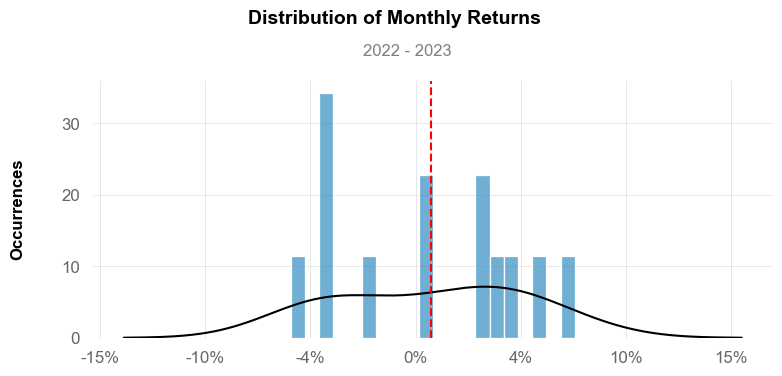

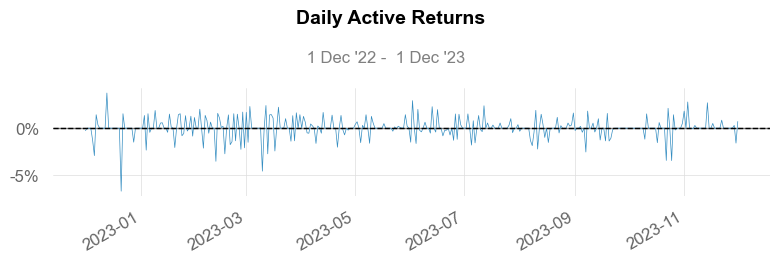

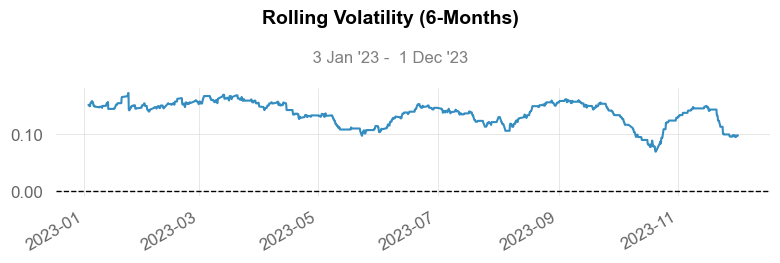

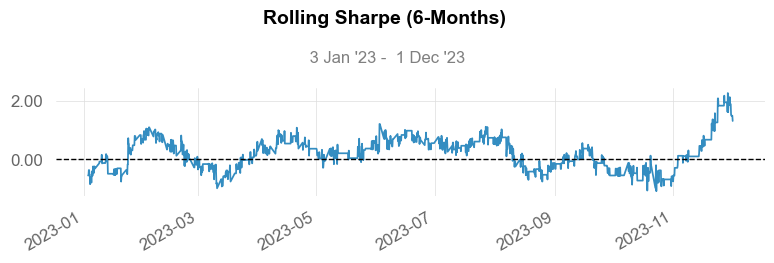

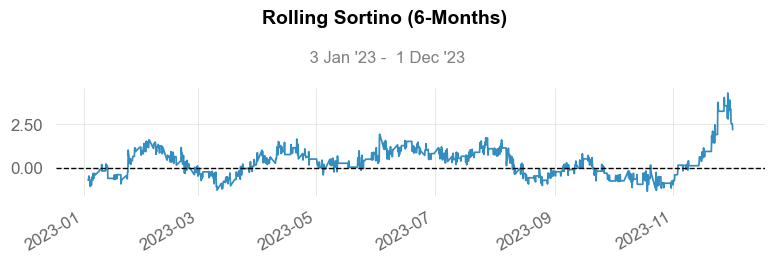

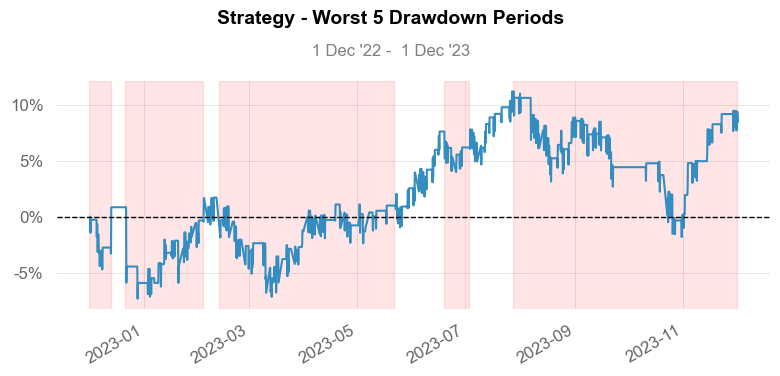

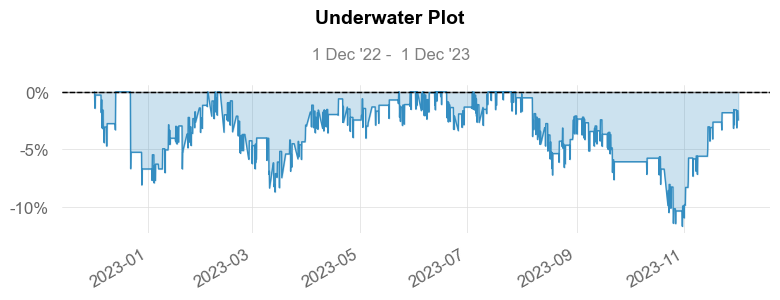

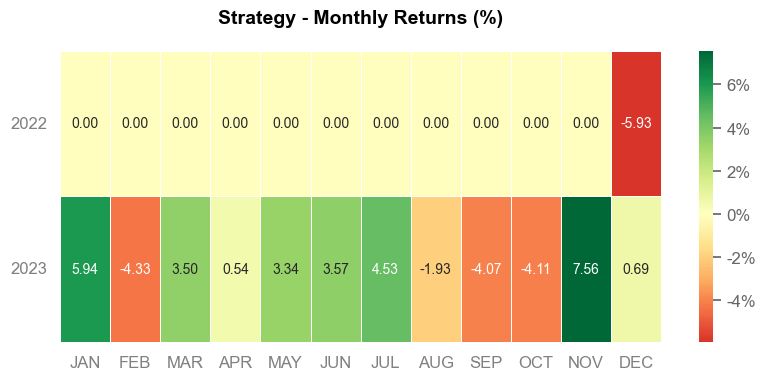

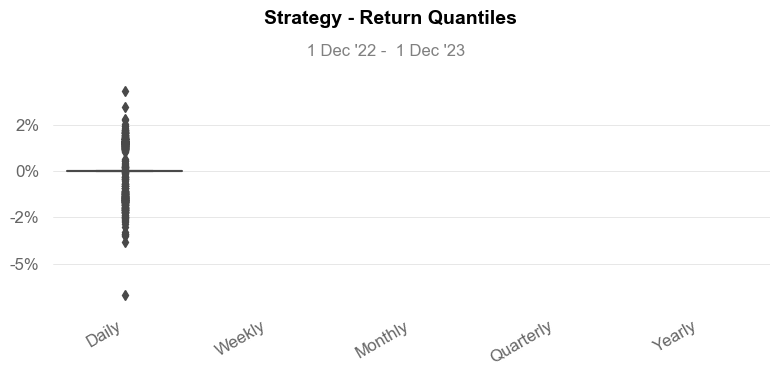

In [31]:
qs.extend_pandas()

net_worth_d = pd.Series(env.unwrapped.history['total_profit'], index=df_d.index[6173:7725])
returns_d = net_worth_d.pct_change().iloc[1:]

qs.reports.full(returns_d)
qs.reports.html(returns_d, output=r'C:\Users\buste\Downloads\EURUSD-H1\df_d_ppo_model_quantstats.html')


In [32]:
env.close()

### Comparing architectures

Testing a [128,128,128] Neural Network versus a [128,64,32] Neural Network.

In [41]:
def make_env():
    env = MyCustomEnv(df=df_b, window_size=100, frame_bound=(100,8400))
    env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
    return env

env = DummyVecEnv([make_env])  # Use the make_env function to create environments
print("Action Space:", env.action_space)
print("Type of Action Space:", type(env.action_space))

TradingEnv __init__
Prices shape: (7725,)
Signal features shape: (7725, 9)
Action Space: Discrete(2)
Type of Action Space: <class 'gymnasium.spaces.discrete.Discrete'>


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [115]:
def make_env():
    def _init():
        env = MyCustomEnv(df=df, window_size=100, frame_bound=(100,1006))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        return env
    return _init
# Create a list of environment instances
envs = [make_env() for _ in range(4)]  # Creating four separate environments
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 128, 128], vf=[128, 128, 128])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=1000000)

Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Using cpu device
Logging to C:/Training\Logs\PPO_27
-----------------------------
| time/              |      |
|    fps             | 3792 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1105         |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0089270305 |
|    clip_fraction        | 0.0702       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | 0.000265     |
| 

In [116]:
stats = env.get_attr("get_statistics")[0]()
print("Average Reward:", stats['average_reward'])
print("Average Length:", stats['average_length'])

Average Reward: 65.83557553956838
Average Length: 905.0


In [112]:
def make_env():
    def _init():
        env = MyCustomEnv(df=df, window_size=100, frame_bound=(100,1006))
        env = MemoryMonitor(env)  # Wrap the environment with the MemoryMonitor
        return env
    return _init
# Create a list of environment instances
envs = [make_env() for _ in range(4)]  # Creating four separate environments
env = DummyVecEnv(envs)  # Use the list of make_env functions to create environments
net_arch = dict(pi=[128, 64, 32], vf=[128, 64, 32])
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path,
            policy_kwargs={'net_arch': net_arch, 'log_std_init': -3, 'ortho_init': False},
            learning_rate=0.0003,  # Adjusted learning rate for stability
            batch_size=64,  # Smaller batch size for more frequent updates
            n_steps=2048,  # Number of steps to run for each environment per update
            gamma=0.99,  # Discount factor
            gae_lambda=0.95,  # Factor for trade-off between bias and variance in GAE
            ent_coef=0.0,  # Entropy coefficient for exploration, set to 0 to focus on exploitation
            vf_coef=1,  # Value function coefficient
            max_grad_norm=0.5)  # Normalizing gradients
model.learn(total_timesteps=1000000)

Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Prices shape: (1006,)
Signal features shape: (1006, 8)
Using cpu device
Logging to C:/Training\Logs\PPO_26


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



-----------------------------
| time/              |      |
|    fps             | 3178 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1134         |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0063341707 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.686       |
|    explained_variance   | -0.000128    |
|    learning_rate        | 0.0003       |
|    loss                 | 273          |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.000828     |
|    value_loss           | 264          |
------------------------------------------
----------------

In [113]:
stats = env.get_attr("get_statistics")[0]()
print("Average Reward:", stats['average_reward'])
print("Average Length:", stats['average_length'])

Average Reward: 72.40622302158286
Average Length: 905.0


In [114]:
env.close()

We can see the second model, acheieved a higher average reward of 72.4 compared to the former architecture which achieved 65.8. Thereofre in our research, the [128,64,32] neural network will be used.

## Tensorboard features extraction

In [36]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to the TensorBoard log directory
path = r'C:\Training\logs\PPO_61'

# Initialize the accumulator
event_acc = EventAccumulator(path)
event_acc.Reload()
print(event_acc.scalars.Keys())
# Extract and print metrics
print("Loss:", event_acc.Scalars('train/loss'))
print("Value Loss:", event_acc.Scalars('train/value_loss'))
print("Explained Variance:", event_acc.Scalars('train/explained_variance'))
print("Entropy Loss:", event_acc.Scalars('train/entropy_loss'))

['time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']
Loss: [ScalarEvent(wall_time=1723917947.0030396, step=16384, value=3824.870849609375), ScalarEvent(wall_time=1723917966.2440443, step=24576, value=2401.543212890625), ScalarEvent(wall_time=1723917984.4341574, step=32768, value=3255.181640625), ScalarEvent(wall_time=1723918002.2838213, step=40960, value=1941.1776123046875), ScalarEvent(wall_time=1723918017.8649142, step=49152, value=2013.0635986328125), ScalarEvent(wall_time=1723918034.0366423, step=57344, value=6547.04833984375), ScalarEvent(wall_time=1723918051.544584, step=65536, value=2257.71044921875), ScalarEvent(wall_time=1723918069.487962, step=73728, value=1782.038818359375), ScalarEvent(wall_time=1723918087.112113, step=81920, value=4262.7890625), ScalarEvent(wall_time=1723918104.2225356, step=90112, value=2188.1860351

In [39]:
def extract_and_save_metrics(log_dir, output_dir,mName,fName):
    # List all subdirectories containing TensorBoard logs
    path = os.path.join(log_dir, mName)
    if os.path.isdir(path):
        print(f"Processing: {fName}")
        event_acc = EventAccumulator(path)
        event_acc.Reload()

        # List of metrics to extract
        metrics = ['train/loss', 'train/value_loss', 'train/explained_variance', 'train/entropy_loss']

        # Extract and save each metric
        for metric in metrics:
            values = []
            times = []
            steps = []
            metric_name = metric.split('/')[-1]
            if metric in event_acc.Tags()['scalars']:
                for event in event_acc.Scalars(metric):
                    times.append(event.wall_time)
                    steps.append(event.step)
                    values.append(event.value)
                
                df = pd.DataFrame(data={'Wall Time': times, 'Step': steps, metric: values})
                csv_path = os.path.join(output_dir, f"{fName}_{metric_name}.csv")
                df.to_csv(csv_path, index=False)
                print(f"Saved {metric} to {csv_path}")

# Specify the directory where your TensorBoard logs are stored and the output directory for the CSV files
log_dir = r'C:\Training\logs'
output_dir = r'C:\Training\metrics'
extract_and_save_metrics(log_dir, output_dir, 'PPO_61', 'df_d_ppo_model')

Processing: df_d_ppo_model
Saved train/loss to C:\Training\metrics\df_d_ppo_model_loss.csv
Saved train/value_loss to C:\Training\metrics\df_d_ppo_model_value_loss.csv
Saved train/explained_variance to C:\Training\metrics\df_d_ppo_model_explained_variance.csv
Saved train/entropy_loss to C:\Training\metrics\df_d_ppo_model_entropy_loss.csv


In [40]:

extract_and_save_metrics(log_dir, output_dir, 'PPO_59', 'df_c_ppo_model')

Processing: df_c_ppo_model
Saved train/loss to C:\Training\metrics\df_c_ppo_model_loss.csv
Saved train/value_loss to C:\Training\metrics\df_c_ppo_model_value_loss.csv
Saved train/explained_variance to C:\Training\metrics\df_c_ppo_model_explained_variance.csv
Saved train/entropy_loss to C:\Training\metrics\df_c_ppo_model_entropy_loss.csv


In [44]:
extract_and_save_metrics(log_dir, output_dir, 'PPO_56', 'df_b_ppo_model')

Processing: df_b_ppo_model
Saved train/loss to C:\Training\metrics\df_b_ppo_model_loss.csv
Saved train/value_loss to C:\Training\metrics\df_b_ppo_model_value_loss.csv
Saved train/explained_variance to C:\Training\metrics\df_b_ppo_model_explained_variance.csv
Saved train/entropy_loss to C:\Training\metrics\df_b_ppo_model_entropy_loss.csv


In [45]:
extract_and_save_metrics(log_dir, output_dir, 'PPO_55', 'df_a_ppo_model')

Processing: df_a_ppo_model
Saved train/loss to C:\Training\metrics\df_a_ppo_model_loss.csv
Saved train/value_loss to C:\Training\metrics\df_a_ppo_model_value_loss.csv
Saved train/explained_variance to C:\Training\metrics\df_a_ppo_model_explained_variance.csv
Saved train/entropy_loss to C:\Training\metrics\df_a_ppo_model_entropy_loss.csv


#### Generating plots for all 4 metrics.

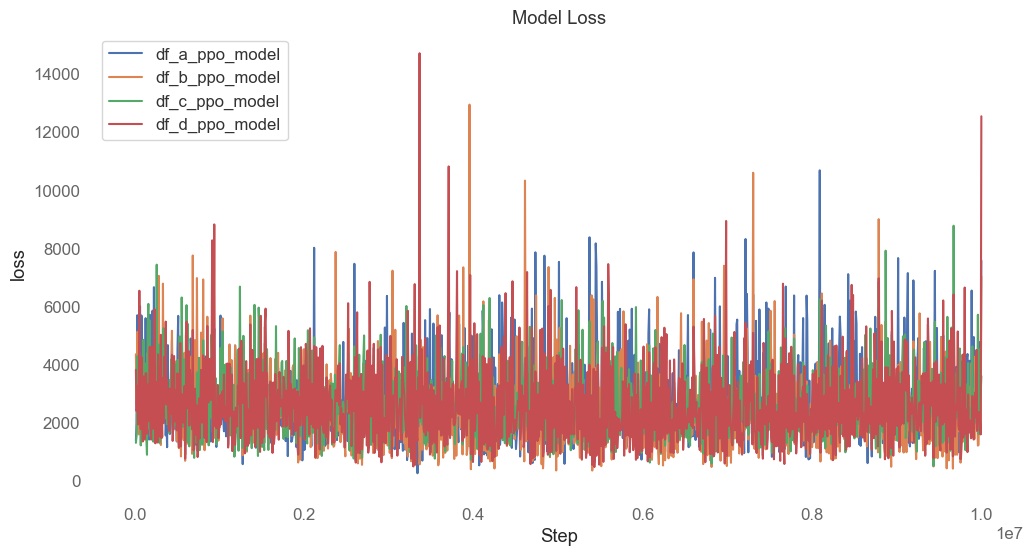

In [56]:
#Plotting the model_loss metric of all 4 models on the same plot.
def plot_metric(model_names, metric_name, output_dir,plot_title):
    plt.figure(figsize=(12, 6))
    for mName in model_names:
        csv_path = os.path.join(output_dir, f"{mName}_{metric_name}.csv")
        df = pd.read_csv(csv_path)
        plt.plot(df['Step'], df['train/'+metric_name], label=mName)

    plt.xlabel('Step')
    plt.ylabel(metric_name)
    plt.title(plot_title)
    plt.legend()
    plt.grid()
    plt.show()

model_names = ['df_a_ppo_model', 'df_b_ppo_model', 'df_c_ppo_model', 'df_d_ppo_model']
plot_metric(model_names,'loss', output_dir, 'Model Loss')

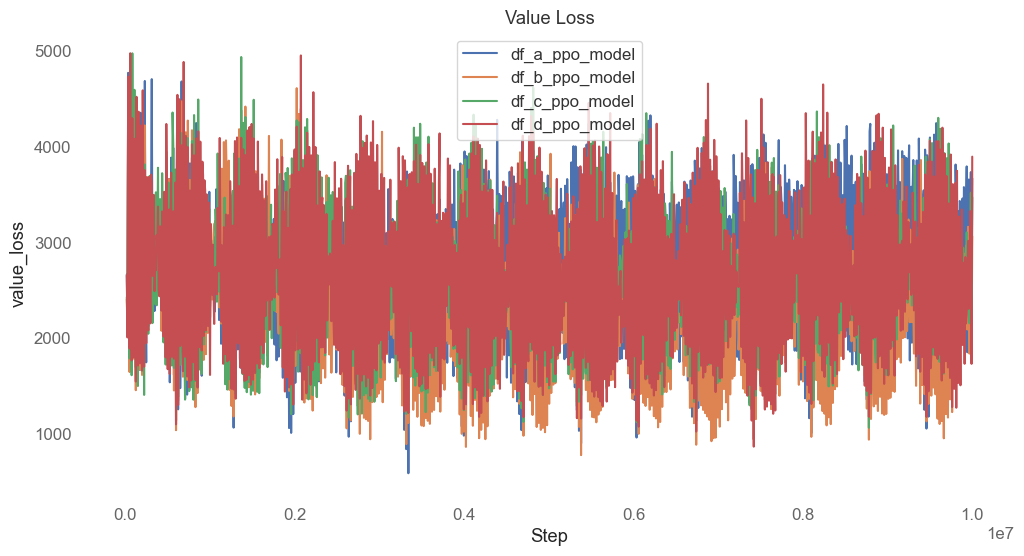

In [57]:
plot_metric(model_names, 'value_loss', output_dir, 'Value Loss')

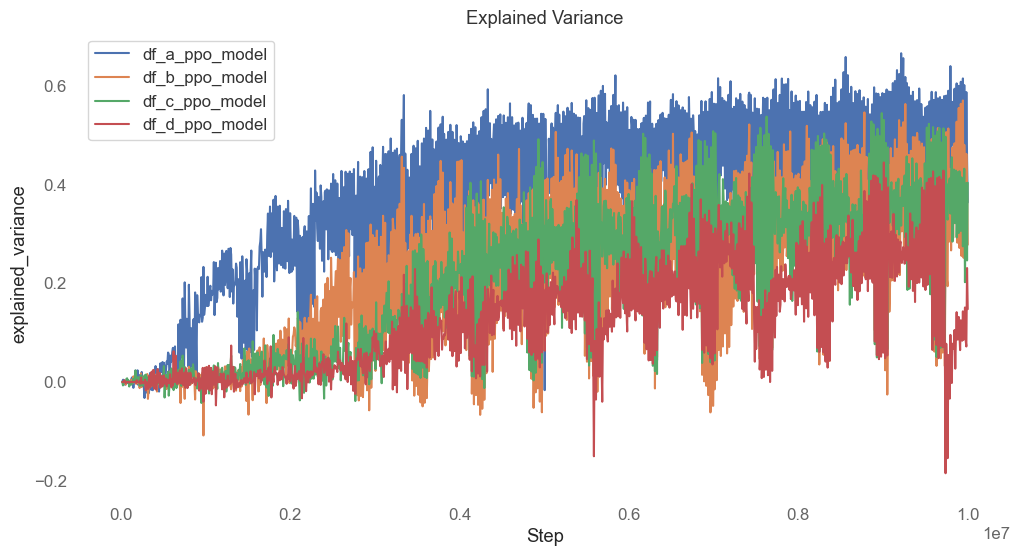

In [58]:
plot_metric(model_names, 'explained_variance', output_dir, 'Explained Variance')

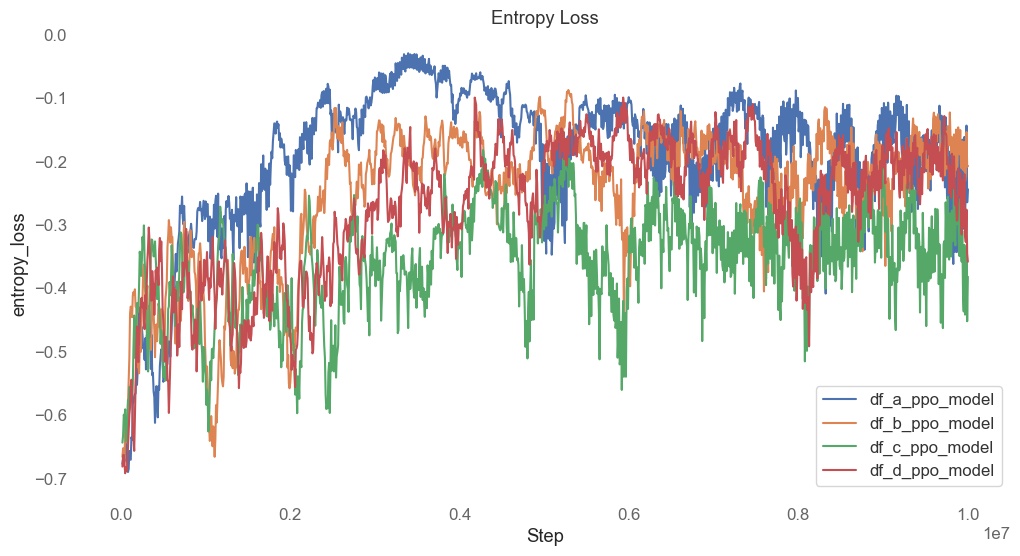

In [59]:
plot_metric(model_names, 'entropy_loss', output_dir, 'Entropy Loss')

### Generating plots for showing positions taken but with smaller circles.

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 6)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



info {'total_reward': 410.40000000000055, 'total_profit': 1.1026277249706087, 'position': 1}
2023-12-01 18:00:00


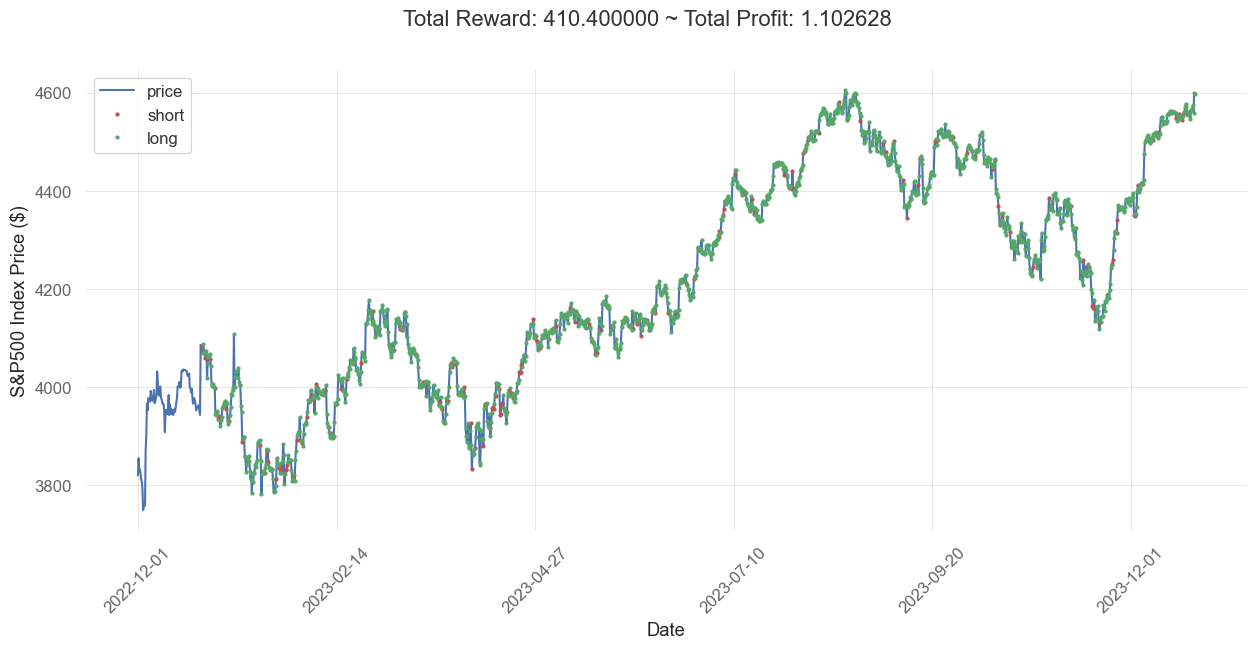

In [18]:
env = MyCustomEnv(df=df_a, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_a_ppo_model', env=env)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.ylabel('S&P500 Index Price ($)')
# plot the x axis labels as the date range from 6172 to 7725
plt.xlabel('Date')
# Make sure the dataframe index is used correctly
dates = pd.to_datetime(df_a.iloc[6172:7725].index)  # Use iloc for positional indexing if the index is not default integers
print(dates[-1])
# Generate x-ticks for plotting
xticks = np.linspace(0, len(dates)-1, 6)  # Change 10 to another number if you need more or fewer labels
xlabels = [dates[int(i)].strftime('%Y-%m-%d') for i in xticks]  # Format date strings

plt.xticks(ticks=xticks, labels=xlabels, rotation=45)  # Set xticks
plt.show()

In [19]:
env.close()

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 10)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



info {'total_reward': 727.8999999999996, 'total_profit': 1.1127356799628478, 'position': 1}
2023-12-01 18:00:00+00:00


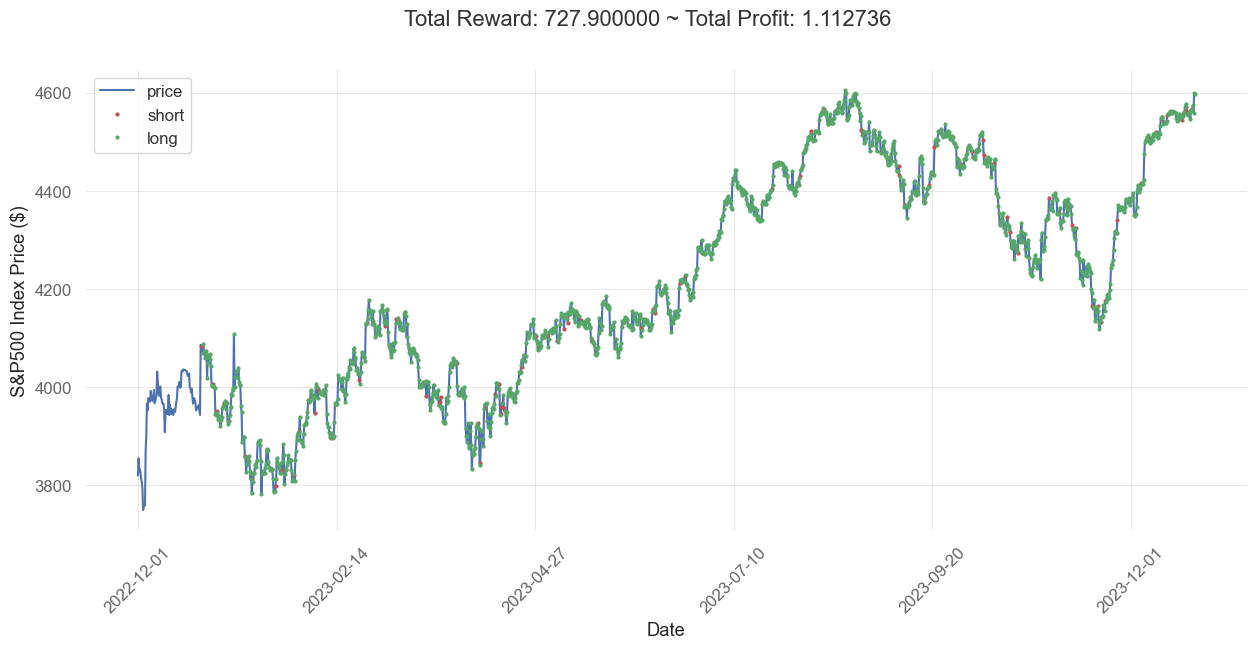

In [22]:
env = MyCustomEnv(df=df_b, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_b_ppo_model', env=env)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.ylabel('S&P500 Index Price ($)')
# plot the x axis labels as the date range from 6172 to 7725
plt.xlabel('Date')
# Make sure the dataframe index is used correctly
dates = pd.to_datetime(df_b.iloc[6172:7725].index)  # Use iloc for positional indexing if the index is not default integers
print(dates[-1])
# Generate x-ticks for plotting
xticks = np.linspace(0, len(dates)-1, 6)  # Change 10 to another number if you need more or fewer labels
xlabels = [dates[int(i)].strftime('%Y-%m-%d') for i in xticks]  # Format date strings

plt.xticks(ticks=xticks, labels=xlabels, rotation=45)  # Set xticks
plt.show()

In [23]:
env.close()

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 14)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



info {'total_reward': 1474.0000000000036, 'total_profit': 1.0919288915134504, 'position': 0}
2023-12-01 18:00:00+00:00


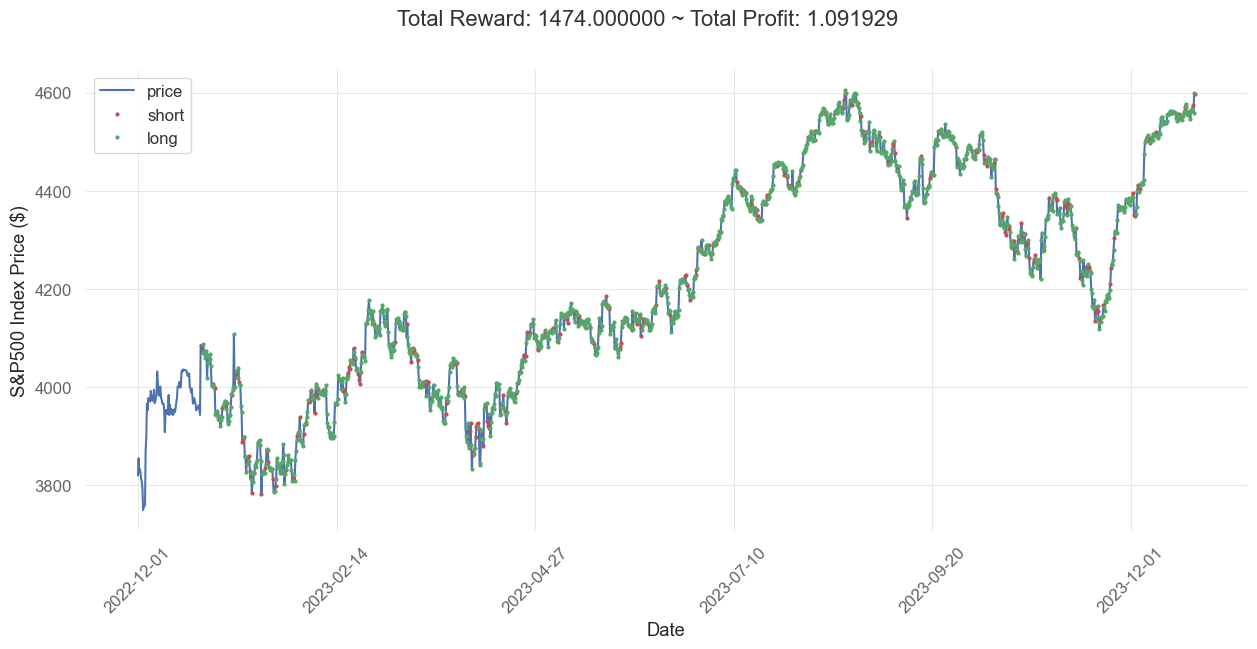

In [26]:
env = MyCustomEnv(df=df_c, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_c_ppo_model', env=env)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.ylabel('S&P500 Index Price ($)')
# plot the x axis labels as the date range from 6172 to 7725
plt.xlabel('Date')
# Make sure the dataframe index is used correctly
dates = pd.to_datetime(df_c.iloc[6172:7725].index)  # Use iloc for positional indexing if the index is not default integers
print(dates[-1])
# Generate x-ticks for plotting
xticks = np.linspace(0, len(dates)-1, 6)  # Change 10 to another number if you need more or fewer labels
xlabels = [dates[int(i)].strftime('%Y-%m-%d') for i in xticks]  # Format date strings

plt.xticks(ticks=xticks, labels=xlabels, rotation=45)  # Set xticks
plt.show()

In [27]:
env.close()

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 18)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



info {'total_reward': -384.80000000000473, 'total_profit': 1.0987751102024959, 'position': 0}
2023-12-01 18:00:00+00:00


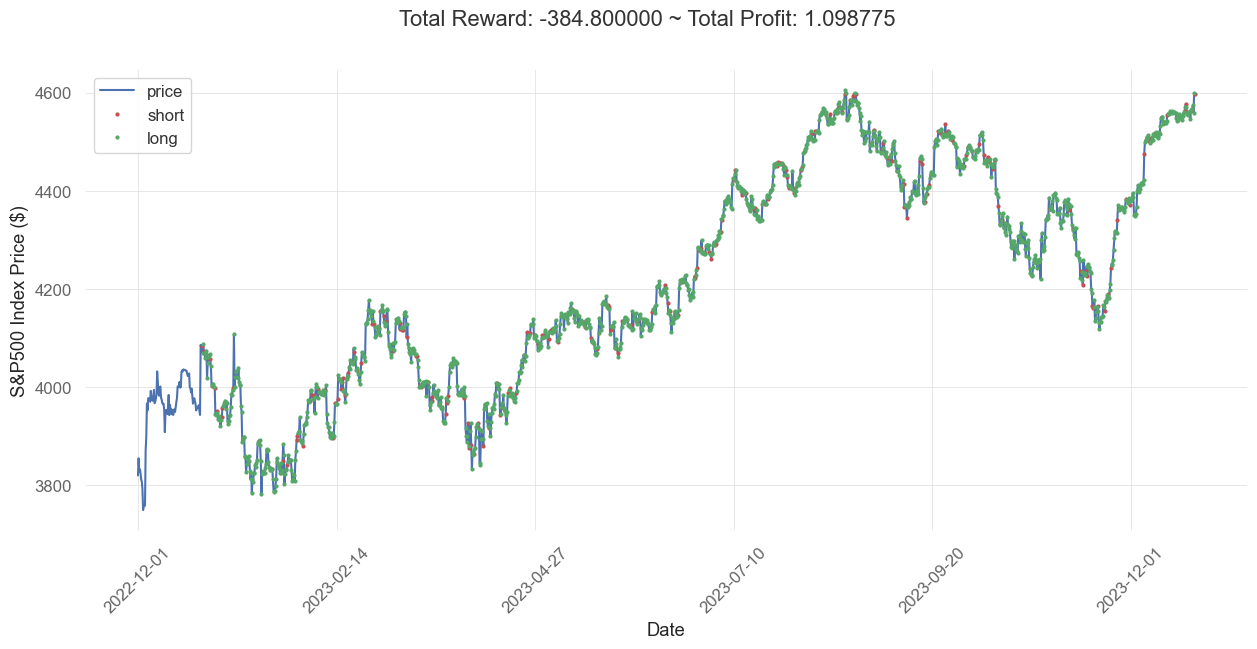

In [30]:
env = MyCustomEnv(df=df_d, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_d_ppo_model', env=env)
obs = env.reset()  # This should have the shape (100, 8)
while True: 
    obs = obs[np.newaxis, :]  # Add a batch dimension correctly
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break  # Exit loop if the episode is done
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.ylabel('S&P500 Index Price ($)')
# plot the x axis labels as the date range from 6172 to 7725
plt.xlabel('Date')
# Make sure the dataframe index is used correctly
dates = pd.to_datetime(df_d.iloc[6172:7725].index)  # Use iloc for positional indexing if the index is not default integers
print(dates[-1])
# Generate x-ticks for plotting
xticks = np.linspace(0, len(dates)-1, 6)  # Change 10 to another number if you need more or fewer labels
xlabels = [dates[int(i)].strftime('%Y-%m-%d') for i in xticks]  # Format date strings

plt.xticks(ticks=xticks, labels=xlabels, rotation=45)  # Set xticks
plt.show()

In [31]:
env.close()

## Equity curves

In [31]:
env = MyCustomEnv(df=df_a, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_a_ppo_model', env=env)

# Initialize the environment and get the starting observation
obs = env.reset()

# Simulate the environment
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

# Assuming the environment has a 'history' attribute that stores total profit at each step
net_worth_a = pd.Series(env.unwrapped.history['total_profit'], index=df_a.index[6173:7725])
returns_a = net_worth_a.pct_change().iloc[1:]

# Save the equity curve to CSV
equity_df = pd.DataFrame({'Date': net_worth_a.index, 'Equity': net_worth_a.values})
equity_df.to_csv('equity_curve_df_a.csv', index=False)

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 6)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
env.close()

In [37]:
env = MyCustomEnv(df=df_b, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_b_ppo_model', env=env)

# Initialize the environment and get the starting observation
obs = env.reset()

# Simulate the environment
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

# Assuming the environment has a 'history' attribute that stores total profit at each step
net_worth_b = pd.Series(env.unwrapped.history['total_profit'], index=df_b.index[6173:7725])
returns_b = net_worth_b.pct_change().iloc[1:]

# Save the equity curve to CSV
equity_df = pd.DataFrame({'Date': net_worth_b.index, 'Equity': net_worth_b.values})
equity_df.to_csv('equity_curve_df_b.csv', index=False)

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 10)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [38]:
env.close()

In [41]:
env = MyCustomEnv(df=df_c, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_c_ppo_model', env=env)

# Initialize the environment and get the starting observation
obs = env.reset()

# Simulate the environment
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

# Assuming the environment has a 'history' attribute that stores total profit at each step
net_worth_c = pd.Series(env.unwrapped.history['total_profit'], index=df_c.index[6173:7725])
returns_c = net_worth_c.pct_change().iloc[1:]

# Save the equity curve to CSV
equity_df = pd.DataFrame({'Date': net_worth_c.index, 'Equity': net_worth_c.values})
equity_df.to_csv('equity_curve_df_c.csv', index=False)

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 14)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [42]:
env.close()

In [45]:
env = MyCustomEnv(df=df_d, window_size=100, frame_bound=(6172,7725))
env.seed(2002)
model = PPO.load(r'C:\Users\buste\Downloads\EURUSD-H1\df_d_ppo_model', env=env)

# Initialize the environment and get the starting observation
obs = env.reset()

# Simulate the environment
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

# Assuming the environment has a 'history' attribute that stores total profit at each step
net_worth_d = pd.Series(env.unwrapped.history['total_profit'], index=df_d.index[6173:7725])
returns_d = net_worth_d.pct_change().iloc[1:]

# Save the equity curve to CSV
equity_df = pd.DataFrame({'Date': net_worth_d.index, 'Equity': net_worth_d.values})
equity_df.to_csv('equity_curve_df_d.csv', index=False)

TradingEnv __init__
TradingEnv seed is: 42
Prices shape: (1653,)
Signal features shape: (1653, 18)
TradingEnv seed is: 2002
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\buste\anaconda3\envs\GME2\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [46]:
env.close()

In [52]:
print(equity_a.index)

Index(['2022-12-01 06:00:00', '2022-12-01 10:00:00', '2022-12-01 14:00:00',
       '2022-12-01 18:00:00', '2022-12-01 22:00:00', '2022-12-02 02:00:00',
       '2022-12-02 06:00:00', '2022-12-02 10:00:00', '2022-12-02 14:00:00',
       '2022-12-02 18:00:00',
       ...
       '2023-11-30 06:00:00', '2023-11-30 10:00:00', '2023-11-30 14:00:00',
       '2023-11-30 18:00:00', '2023-11-30 22:00:00', '2023-12-01 02:00:00',
       '2023-12-01 06:00:00', '2023-12-01 10:00:00', '2023-12-01 14:00:00',
       '2023-12-01 18:00:00'],
      dtype='object', name='Date', length=1552)


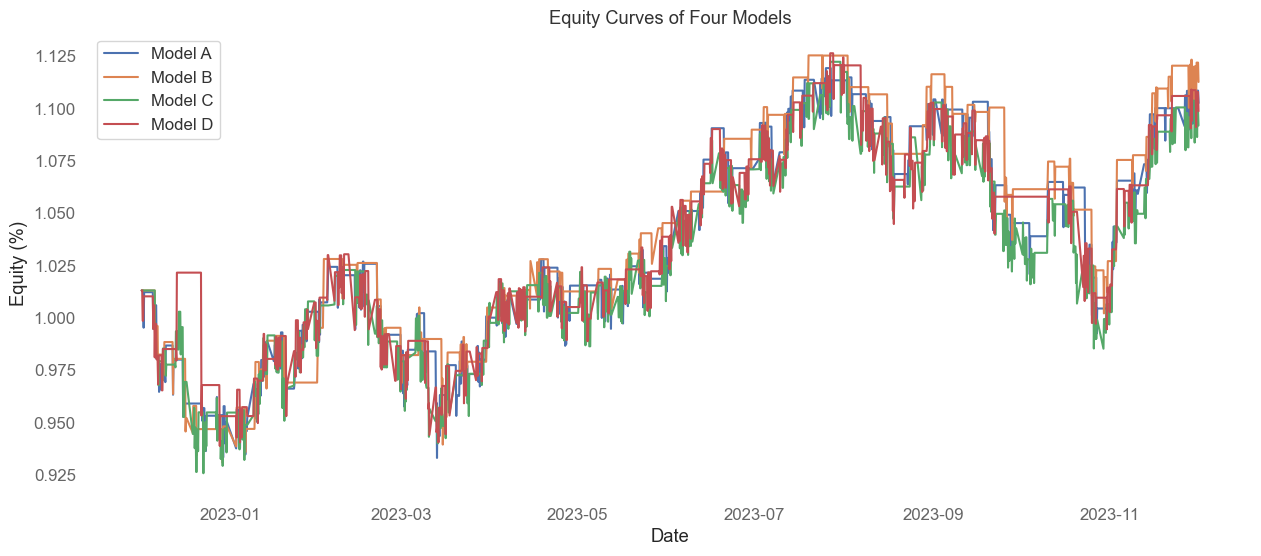

In [15]:
# Load the equity curves from the CSV files
equity_a = pd.read_csv('equity_curve_df_a.csv')
equity_b = pd.read_csv('equity_curve_df_b.csv')
equity_c = pd.read_csv('equity_curve_df_c.csv')
equity_d = pd.read_csv('equity_curve_df_d.csv')

# Plot the equity curves with the date on the x-axis
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(equity_a['Date']), equity_a['Equity'], label='Model A')
plt.plot(pd.to_datetime(equity_b['Date']), equity_b['Equity'], label='Model B')
plt.plot(pd.to_datetime(equity_c['Date']), equity_c['Equity'], label='Model C')
plt.plot(pd.to_datetime(equity_d['Date']), equity_d['Equity'], label='Model D')
plt.xlabel('Date')
plt.ylabel('Equity (%)')
plt.title('Equity Curves of Four Models')
plt.legend()
plt.grid()
plt.show()

In [22]:
df_a.loc['2023-12-01']

Open    High     Low   Close  Volume     Delta
dt                                                                   
2023-12-01 02:00:00  4565.4  4569.1  4564.1  4566.6     770  0.000088
2023-12-01 06:00:00  4566.6  4576.9  4564.9  4573.9    2098  0.000263
2023-12-01 10:00:00  4573.9  4573.9  4557.6  4558.6    2107  0.001599
2023-12-01 14:00:00  4558.6  4601.0  4555.2  4598.6   11764 -0.003345
2023-12-01 18:00:00  4598.6  4599.4  4586.6  4597.7    4400  0.008775

In [24]:
# Buy 1% of 1, the S&P 500 the first candle of the first day of dec 2022 and sell at the last candle of the df
# Calculate the total profit
initial_price = df_a.loc['2022-12-01 02:00:00', 'Close']
final_price = df_a.loc['2023-12-01 02:00:00', 'Close']
price_diff = final_price - initial_price
total_profit = price_diff / initial_price * 100
print(f"Total Profit: {total_profit:.2f}%")

Total Profit: 11.83%
